<img style="float: left;" src="icon.jpg">
<img style="float: right;" src="https://www.tudublin.ie/media/website/site-assets/images/tu-dublin-logo-blue.svg">

<br><br><br><br>

# Eye of Another World :: Weapon Visualizer


by Jorge Jimenez Garcia</a> 


## Sections:
* <a href="#dep_and_prereq"> Dependencies, Imports, Prerequisites and Global Configs </a>
* <a href="#prelude">Prelude </a>
* <a href="#visualization"> Visualization </a>
    * <a href="#usage stats"> Usage Statistics </a>
    * <a href="#density"> Density plots </a>

<a name="dep_and_prereq"> </a>
## Dependencies, Imports, Prerequisites and Global Configs

In [1]:

# IMPORTS-------------------------
import sqlite3
from collections import Counter
import ctypes
import pickle
import json
import zipfile
import requests
import os
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline

# CONSTANTS-----------------------------
BNET_URL = 'http://Bungie.net'
MANIFEST_SUFFIX = '/Platform/Destiny2/Manifest/'
WEAPON_SLOT_NAMES = ['', 'Primary', 'Special', 'Power']

PROPERTIES_QUERY = """
SELECT json_extract(json, '$.displayProperties.name'), json_extract(json, '$.inventory.tierTypeName'), json_extract(json, '$.itemTypeDisplayName'), json_extract(json, '$.equippingBlock.ammoType'), json_extract(json, '$.sockets'), json_extract(json, '$.stats.stats')
FROM DestinyInventoryItemDefinition
WHERE id == {}
"""
FRAME_NAME_QUERY = """
SELECT json_extract(json, '$.displayProperties.name')
FROM DestinyInventoryItemDefinition
WHERE id == {}
"""

PERK_SET_QUERY = """
SELECT json_extract(json, '$.reusablePlugItems')
FROM DestinyPlugSetDefinition
WHERE id == {}
"""

PERK_QUERY = """
SELECT json_extract(json, '$.displayProperties.name')
FROM DestinyInventoryItemDefinition
WHERE id == {} AND json_extract(json, '$.itemTypeDisplayName') == 'Trait'
"""

ALL_PERKS_QUERY = """
SELECT json_extract(json, '$.displayProperties.name')
FROM DestinyInventoryItemDefinition
WHERE json_extract(json, '$.itemTypeDisplayName') == 'Trait'
"""

HASH_STABILITY = str(155624089)
HASH_HANDLING = str(943549884)
HASH_RANGE = str(1240592695)
HASH_AIMASSIST = str(1345609583)
HASH_AIRBORNEEFF = str(2714457168)
HASH_RECOILDIR = str(2715839340)
HASH_ZOOM = str(3555269338)
HASH_MAGSIZE = str(3871231066)
HASH_IMPACT = str(4043523819)
HASH_RELOAD = str(4188031367)
HASH_RPM = str(4284893193)

# Specific stats to certain weapon types

HASH_FR_CHARGETIME = str(2961396640)

#bows have chargetime? id == to fusion chargetime, but the stat is always 0?
HASH_BOW_DRAWTIME = str(447667954) # ~rpm?
HASH_BOW_ACCURACY = str(1591432999)

HASH_RLGL_VELOCITY = str(2523465841)
HASH_RLGL_BLASTRADIUS = str(3614673599)

HASH_GLAIVE_SHIELDDUR = str(1842278586)

HASH_SWORD_GUARDRES = str(209426660)
HASH_SWORD_GUARDEFF = str(2762071195)
HASH_SWORD_SWINGSPEED = str(2837207746) # ~rpm?
HASH_SWORD_CHARGERATE = str(3022301683)

# Socket constants

HASH_SOCKET_WEAPONPERK = 4241085061


_Config settings:_


#### `CONFIG__DF_IGNORE_EXOTICS`: Why leave out Exotic weapons?

Exotic weapons are the stand out in a players arsenal. Unique in their behaviour, they would be useless data in our study, since they have traits generally exclusive to them, and so including them in our pool of analyzed traits does not help us predict the popularity of gear, because no other item will have those traits

#### `CONFIG__MERGE_LR_PERK_COLUMNS`: Why merge left and right perk columns?

Our data is extremely square otherwise, and one could argue that keeping a distinction between left and right perk columns does not matter in the majority of the cases.

#### `CONFIG__DATA_FILE_NAME`:

File name to load and process as a dataFrame

In [2]:
# CONFIG----------------------------
CONFIG__DF_IGNORE_EXOTICS = True

CONFIG__DATA_FILE_NAME = 'plunder-RAD2MODE70-from2022-09-23-to2022-10-24'
#CONFIG__DATA_FILE_NAME = 'seraph-RAD2MODE70-from2022-12-09-to2023-02-20'
#CONFIG__DATA_FILE_NAME = 'lightfall-RAD2MODE70-from2023-02-28-to2023-03-22'
CONFIG__MERGE_LR_PERK_COLUMNS = True

#CONFIG__PLT_SIZE
plt.rcParams['figure.figsize'] = [6, 6]

# Force reload of the dataframe
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([6])")

<IPython.core.display.Javascript object>

<a name="prelude" > </a>
## Prelude

### Data Set construction


<br><br>

In [3]:

# Read data file
with open('data/raw/' + CONFIG__DATA_FILE_NAME + '.d2data', 'rb') as f:
    (weaponFreq, gameSet) = pickle.load(f)
    print('Loaded dataSet {}: {} weapon instances ({} unique) across {} unique games.'.format(CONFIG__DATA_FILE_NAME,sum(weaponFreq.values()), len(weaponFreq.keys()), len(gameSet)))
    if CONFIG__DF_IGNORE_EXOTICS:
        print('[INFO]: Config::IgnoreExotics is set: Some instances will be ignored')
    if CONFIG__MERGE_LR_PERK_COLUMNS:
        print('[INFO]: Config::MergeLRColumns is set: perk column belonging will be ignored')

# Check Manifest, and update if needed
try:
    manifests = requests.get(BNET_URL + MANIFEST_SUFFIX).json()
    manifest_location = manifests['Response']['mobileWorldContentPaths']['en']
except KeyError:
    # Sometimes an error is returned saying the endpoint needs authorization, but it doesn't need it? 
    # just retry
    print('Server did not respond: ', manifests['ErrorStatus'], ':', manifests['Message'])
    raise RuntimeError
DB_NAME = manifest_location[35:]
if not os.path.exists(DB_NAME):
    print('{} not found: Downloading Destiny Manifest, this may take a while...'.format(DB_NAME))
    manifest_zip = requests.get(BNET_URL + manifest_location).content
    print('Up-to-date Manifest downloaded:')
    with zipfile.ZipFile(BytesIO(manifest_zip)) as z:
        with open(DB_NAME, 'wb') as f:
            f.write(z.read(DB_NAME))
else:
    print('Manifest found at {}'.format(DB_NAME))


db = sqlite3.connect(DB_NAME).cursor()

name_l = []
weaponid = []
weapon_type = []
weapon_archetype = []
weapon_slot = []
usage_absolute = []
usage_rate = []
usage_rate_slot = []


# Stats
stability = []
handling = []
rang = []
aim_assist = []
airborne_effectiveness = []
recoil_direction = []
zoom = []
magsize = []
impact = []
reload = []
rpm = []

bow_drawtime = []
bow_accuracy = []
fr_chargetime = []
rlgl_velocity = []
rlgl_blastradius = []
glaive_shieldduration = []
sword_guardresistence = []
sword_guardefficiency = []
sword_swingspeed = []
sword_chargerate = []


stat_arr = [stability,handling,rang,aim_assist,airborne_effectiveness,recoil_direction,zoom,magsize,impact,reload,rpm,bow_drawtime,bow_accuracy,fr_chargetime,rlgl_velocity,rlgl_blastradius,glaive_shieldduration,sword_guardresistence,sword_guardefficiency,sword_swingspeed,sword_chargerate]
stat_hash_arr = [HASH_STABILITY,HASH_HANDLING,HASH_RANGE,HASH_AIMASSIST,HASH_AIRBORNEEFF,HASH_RECOILDIR,HASH_ZOOM,HASH_MAGSIZE,HASH_IMPACT,HASH_RELOAD,HASH_RPM,HASH_BOW_DRAWTIME,HASH_BOW_ACCURACY,HASH_FR_CHARGETIME,HASH_RLGL_VELOCITY,HASH_RLGL_BLASTRADIUS,HASH_GLAIVE_SHIELDDUR,HASH_SWORD_GUARDRES,HASH_SWORD_GUARDEFF,HASH_SWORD_SWINGSPEED,HASH_SWORD_CHARGERATE]

all_perks_list = [ e[0] for e in db.execute(ALL_PERKS_QUERY).fetchall() ]

if not CONFIG__MERGE_LR_PERK_COLUMNS:
    left_column = {}
    right_column= {}
    print(len(all_perks_list),'perks in db')
    for e in all_perks_list:
        left_column[e] = []
        right_column[e]= []
else:
    column = {}
    for e in all_perks_list:
        column[e] = []
        
slot_totals = {'Primary': 0, 'Special': 0, 'Power': 0 }
for weaponId, ct in weaponFreq.items():
        name, tier, weaponType, weaponSlot, sockets, stats = db.execute(PROPERTIES_QUERY.format(ctypes.c_int32(weaponId).value)).fetchall()[0]

        weaponSlot = WEAPON_SLOT_NAMES[weaponSlot]
        sockets = json.loads(sockets) # Perks: TODO        
        stats = json.loads(stats)
        
        # Weapon tier filter:
        if tier != 'Exotic':
            frameId = sockets['socketEntries'][0]['singleInitialItemHash']
            frame = db.execute(FRAME_NAME_QUERY.format(ctypes.c_int32(frameId).value)).fetchall()[0][0]
            
            # Unify special frame names THAT DO NOT CHANGE BEHAVIOUR (meaning stuff like Omolon Adaptive for sidearms remains untouched)
            if frame == "Together Forever" or (frame == "Omolon Adaptive Frame" and weaponType != 'Sidearm'):
                frame = "Adaptive Frame"
            elif frame == "MIDA Synergy":
                frame = "Lightweight Frame"
            elif frame == "VEIST Rapid-Fire":
                frame = "Rapid-Fire Frame"
            elif frame == 'Shot Package': # Exception: There *is* a difference here, but it is minimal.
                frame = 'Aggressive Frame'     
        else:
            if CONFIG__DF_IGNORE_EXOTICS:
                continue
            frame = 'Exotic'
            
        # Stats
        for idx, stat_hash in enumerate(stat_hash_arr):
            try:
                stat_arr[idx].append(stats[stat_hash]['value'])
            except KeyError:
                stat_arr[idx].append(-1) # Using None conflicts with certain classifiers (Decs. Trees, etc)
        
        name_l.append(name)
        weaponid.append(weaponId)
        weapon_type.append(weaponType)
        weapon_archetype.append(frame)
        weapon_slot.append(weaponSlot)
        slot_totals[weaponSlot] += ct
        usage_absolute.append(ct)
        
        #print(tier)
        # Non-Legendary/Exotic items do not have perks:
        #if tier not in ['Legendary', 'Exotic']:
        #    continue
        

        # Perks        
        perkindex = []
        #print(name, '//', weaponId)
        for s in sockets['socketCategories']:
            if s['socketCategoryHash'] == HASH_SOCKET_WEAPONPERK:
                perkindex = (s['socketIndexes'])
        #if perkindex == []:
        #    print('Malformed item {} with ID {} had no Weapon Perks!'.format(name, weaponId))
        #    raise RuntimeError
        

        if not CONFIG__MERGE_LR_PERK_COLUMNS:
            # We only expect 2 columns (l/r). Preselect left, fill and then swap to right
            l_col = []
            r_col = []
            selected_column = l_col
        else:
            col = []
            selected_column = col

        for perk_idx in perkindex:
            slot = sockets['socketEntries'][perk_idx]
            
            # Get the set
            
            # Account for 'curated'/'ritual'/weapons with a set choice of perks
            perk_set_hash = slot[ 'randomizedPlugSetHash' if 'randomizedPlugSetHash' in slot else 'reusablePlugSetHash' ]
            perk_set = db.execute(PERK_SET_QUERY.format(ctypes.c_int32(perk_set_hash).value)).fetchall()
            perk_set = json.loads(perk_set[0][0])
            
            for e in perk_set:
                # Check if the item in the set is of type 'Trait': if not, we are not in a perk column
                perkname = db.execute(PERK_QUERY.format(ctypes.c_int32(e['plugItemHash']).value)).fetchall()
                if perkname == []:
                    break
                selected_column.append(perkname[0][0])
                #print('\t\t',perkname[0][0])
            if not CONFIG__MERGE_LR_PERK_COLUMNS and selected_column != []:
                selected_column = r_col
            #print()
        
        #assert (l_col != []) or (r_col != [])
        
        # Update the perk vectors   
        if not CONFIG__MERGE_LR_PERK_COLUMNS:

            for k in left_column.keys():
                if k in l_col:
                    left_column[k] = left_column[k] + [1]
                else:
                    left_column[k] = left_column[k] + [0]
            # HOLD ON! If the item is a Year 1 weapon, it does not have a right column perk
            for k in left_column.keys():
                if k in r_col:
                    right_column[k] = right_column[k] + [1]
                else:
                    right_column[k] = right_column[k] + [0]
        else:
            for k in column.keys():
                if k in col:
                    column[k] = column[k] + [1]
                else:
                    column[k] = column[k] + [0]
        
        
# Usage data
total_count = sum(usage_absolute)
for i in range(len(weapon_slot)):
    slot = weapon_slot[i]
    uabs = usage_absolute[i]
    urat_slot = uabs / slot_totals[slot]
    urat = uabs / total_count
    
    usage_rate.append( urat * 100 )
    usage_rate_slot.append( urat_slot * 100)
    
print("Generating DataFrame: {} weapons accounted ({} unique)".format(total_count, len(usage_rate)))

df = pd.DataFrame(
    {
        'Name': pd.Series(name_l, dtype='category'),
        'Weapon Type': pd.Series(weapon_type, dtype='category'),
        'Archetype': pd.Series(weapon_archetype, dtype='category'),
        'Slot': pd.Series(weapon_slot, dtype='category'),
        'WeaponID': pd.Series(weaponid, dtype='category'),
        'Stability': stability,
        'Handling': handling,
        'Range': rang,
        'Aim Assistance': aim_assist,
        'Airborne Effectiveness': airborne_effectiveness,
        'Recoil Direction': recoil_direction,
        'Zoom': zoom,
        'Magazine Size': magsize,
        'Impact': impact,
        'Reload Speed': reload,
        'Rounds Per Minute': rpm,
        'Draw Time': bow_drawtime,
        'Accuracy': bow_accuracy,
        'Charge Time': fr_chargetime,
        'Velocity': rlgl_velocity,
        'Blast Radius': rlgl_blastradius,
        'Shield Duration': glaive_shieldduration,
        'Guard Resistance': sword_guardresistence,
        'Guard Efficiency': sword_guardefficiency,
        'Swing Speed': sword_swingspeed,
        'Charge Rate': sword_chargerate,
        'Ocurrences': usage_absolute
        
    }
)

# Get perks that appeared at least once on any column:
appears = []
for k in all_perks_list:
    
    if not CONFIG__MERGE_LR_PERK_COLUMNS:
        if sum(right_column.get(k)) + sum(left_column.get(k)) > 0:
            appears.append(k)
    else:
        if sum(column.get(k)) > 0:
            appears.append(k)

# if no perk appears, something has gone horribly wrong
assert appears != []
print(f'{len(appears)} perks detected')

# WARNINGS: pd will constantly complain about performance degradation by adding so many new columns, which
# causes fragmentations. This will later be solved via df.copy() so we disable warnings temporarily

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for k in appears:
    if not CONFIG__MERGE_LR_PERK_COLUMNS:
        df[k + ' in Right Column'] = pd.Series(right_column.get(k, [0 * len(usage_absolute)]), dtype='category')
        df[k + ' in Left Column'] =  pd.Series(left_column.get(k, [0 * len(usage_absolute)]), dtype='category')
    else:
        df[k + ' present in any Column'] = pd.Series(column.get(k, [0 * len(usage_absolute)]), dtype='category')

assert round(sum(usage_rate),2) == 100.0 # FLOATING POINT VALUES MAN, GREAT
assert round(sum(usage_rate_slot),2) == 300.0

df['Usage Rate in Slot (%)'] = usage_rate_slot
df['Global Usage Rate (%)']  = usage_rate

l = []
source_col = df["Global Usage Rate (%)"]
for e in source_col:
    # unpopular: 50% and below
    if e < np.percentile(source_col, 50):
        l.append("Unpopular")
    #niche: 50%-90% 
    elif e < np.percentile(source_col, 90):
        l.append('Niche')
    # popular: 90%+
    else:
        l.append("Popular")

df["Popularity Category"] = l

# Defragment DataFrame
df = df.copy()

# WARNINGS: Re-enable Performance Warnings
warnings.simplefilter(action='default', category=pd.errors.PerformanceWarning)

df.to_csv(CONFIG__DATA_FILE_NAME + '.csv', index=False)
#df.sort_values(by = 'Ocurrences', ascending=False, inplace=True)
#df.reset_index(inplace=True, drop=True)
df

Loaded dataSet plunder-RAD2MODE70-from2022-09-23-to2022-10-24: 27189 weapon instances (565 unique) across 1049 unique games.
[INFO]: Config::IgnoreExotics is set: Some instances will be ignored
[INFO]: Config::MergeLRColumns is set: perk column belonging will be ignored
world_sql_content_c9f9ca5ba28c0aaa4f8a72fd12ee93ce.content not found: Downloading Destiny Manifest, this may take a while...
Up-to-date Manifest downloaded:
Generating DataFrame: 18885 weapons accounted (470 unique)
151 perks detected


,Name,Weapon Type,Archetype,Slot,WeaponID,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,...,Tap the Trigger present in any Column,Meganeura present in any Column,Timed Payload present in any Column,Ambitious Assassin present in any Column,Energy Transfer present in any Column,Slideways present in any Column,Eager Edge present in any Column,Usage Rate in Slot (%),Global Usage Rate (%),Popularity Category
0,Doom of Chelchis,Scout Rifle,Precision Frame,Primary,1937552980,40,39,49,64,17,...,0,0,0,0,0,0,0,0.976290,0.555997,Niche
1,Adored,Sniper Rifle,Adaptive Frame,Special,4184808992,46,47,50,68,2,...,0,0,0,0,0,0,0,1.383013,0.450093,Niche
2,Servant Leader,Scout Rifle,Rapid-Fire Frame,Primary,1107446438,42,18,24,67,10,...,0,0,0,0,0,0,0,0.604370,0.344189,Niche
3,Mindbender's Ambition (Adept),Shotgun,Aggressive Frame,Special,912150785,29,31,29,39,4,...,0,0,0,0,0,1,0,1.155223,0.375960,Niche
4,New Purpose,Pulse Rifle,High-Impact Frame,Primary,1780464822,54,26,65,32,19,...,0,0,0,0,0,0,0,0.725244,0.413026,Niche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,The Number,Auto Rifle,Precision Frame,Primary,2492081469,40,36,50,44,10,...,0,0,0,0,0,0,0,0.009298,0.005295,Unpopular
466,Horror's Least,Pulse Rifle,Rapid-Fire Frame,Primary,1071542914,49,22,34,82,10,...,0,0,0,1,0,0,0,0.009298,0.005295,Unpopular
467,Jorum's Claw,Pulse Rifle,Adaptive Frame,Primary,622058944,50,44,49,60,10,...,0,0,0,0,0,0,0,0.009298,0.005295,Unpopular
468,Patron of Lost Causes,Scout Rifle,Lightweight Frame,Primary,2723241847,32,63,33,67,10,...,0,0,0,0,0,0,0,0.009298,0.005295,Unpopular


In [4]:
df.dtypes

Name                                category
Weapon Type                         category
Archetype                           category
Slot                                category
WeaponID                            category
                                      ...   
Slideways present in any Column     category
Eager Edge present in any Column    category
Usage Rate in Slot (%)               float64
Global Usage Rate (%)                float64
Popularity Category                   object
Length: 172, dtype: object

In [5]:
df.loc[ df['Name'] == 'Better Devils' ]

,Name,Weapon Type,Archetype,Slot,WeaponID,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,...,Tap the Trigger present in any Column,Meganeura present in any Column,Timed Payload present in any Column,Ambitious Assassin present in any Column,Energy Transfer present in any Column,Slideways present in any Column,Eager Edge present in any Column,Usage Rate in Slot (%),Global Usage Rate (%),Popularity Category
339,Better Devils,Hand Cannon,Adaptive Frame,Primary,1048266744,42,40,40,75,10,...,0,0,0,0,0,0,0,0.018596,0.01059,Unpopular
359,Better Devils,Hand Cannon,Adaptive Frame,Primary,153979397,42,40,40,75,10,...,0,0,1,0,0,0,0,0.018596,0.01059,Unpopular


<a name="visualization"> </a>
## Visualization

<a name="usage stats"> </a>
#### Usage statistics:

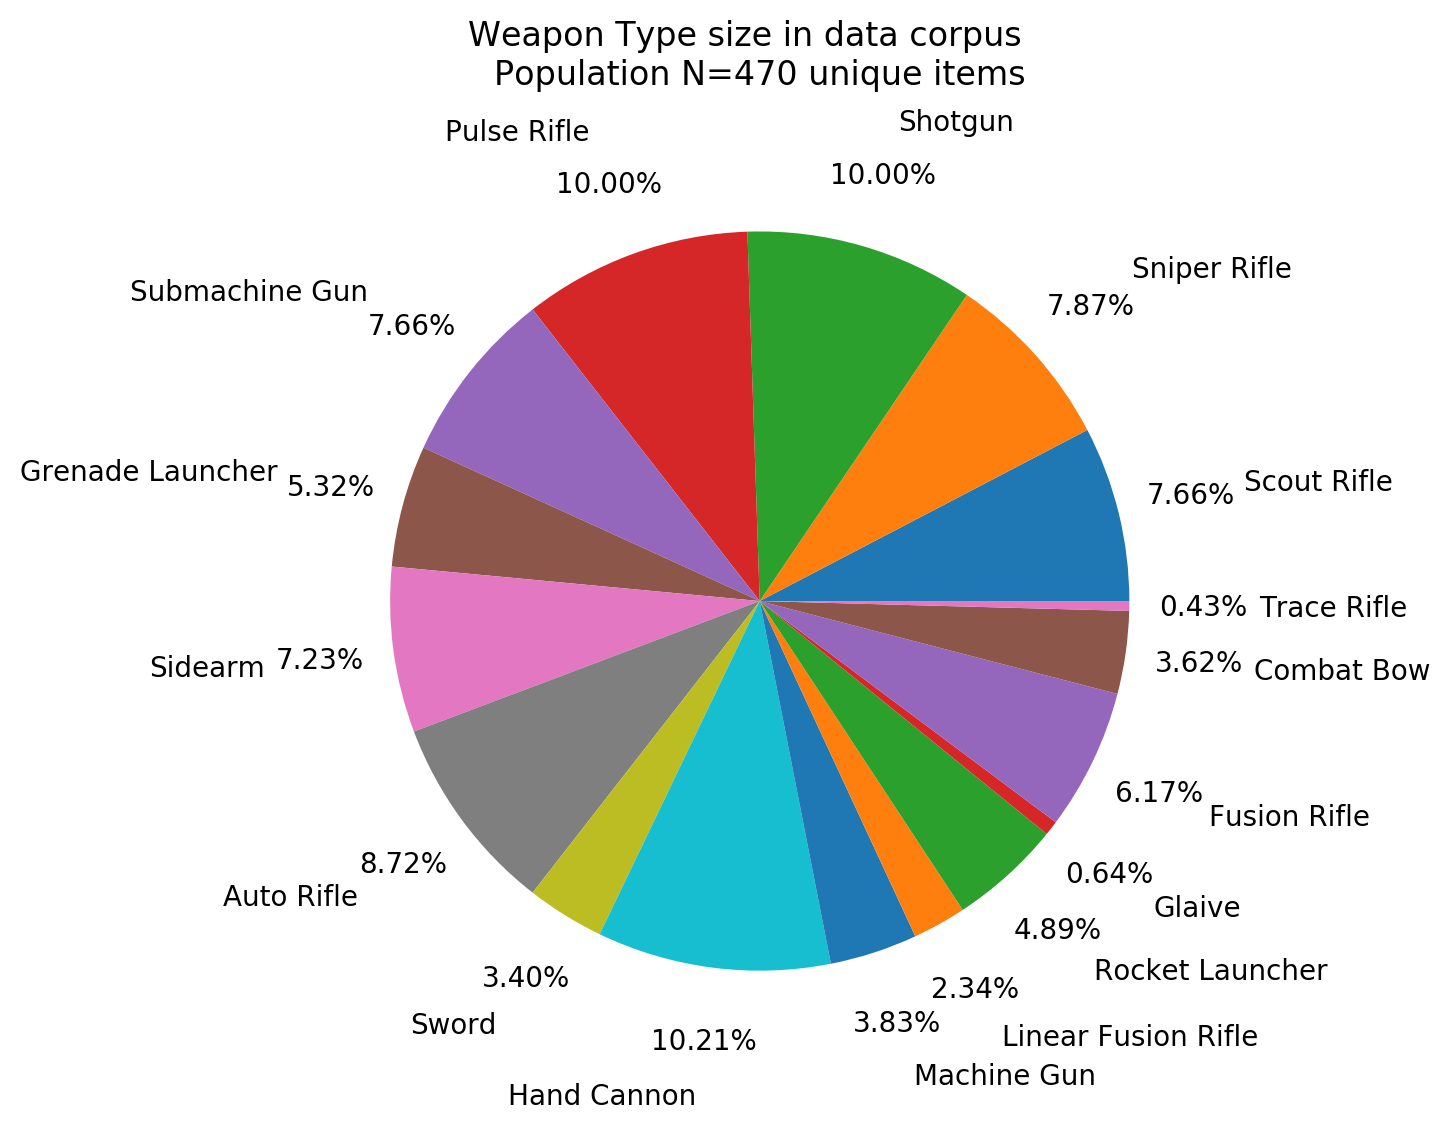

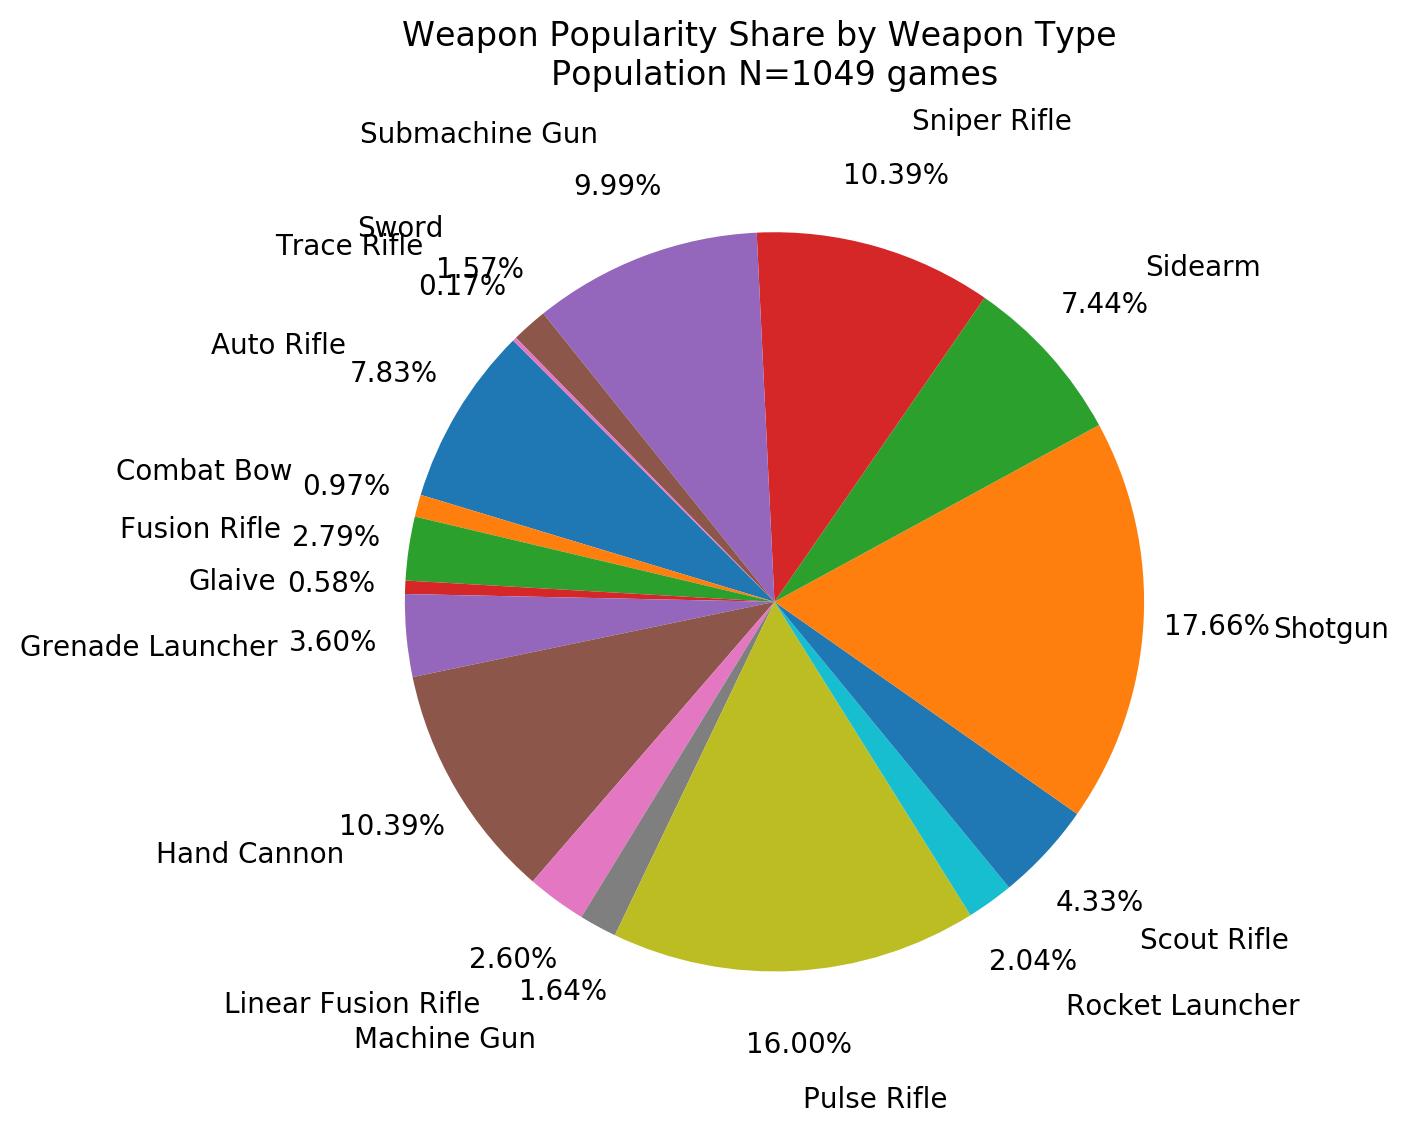

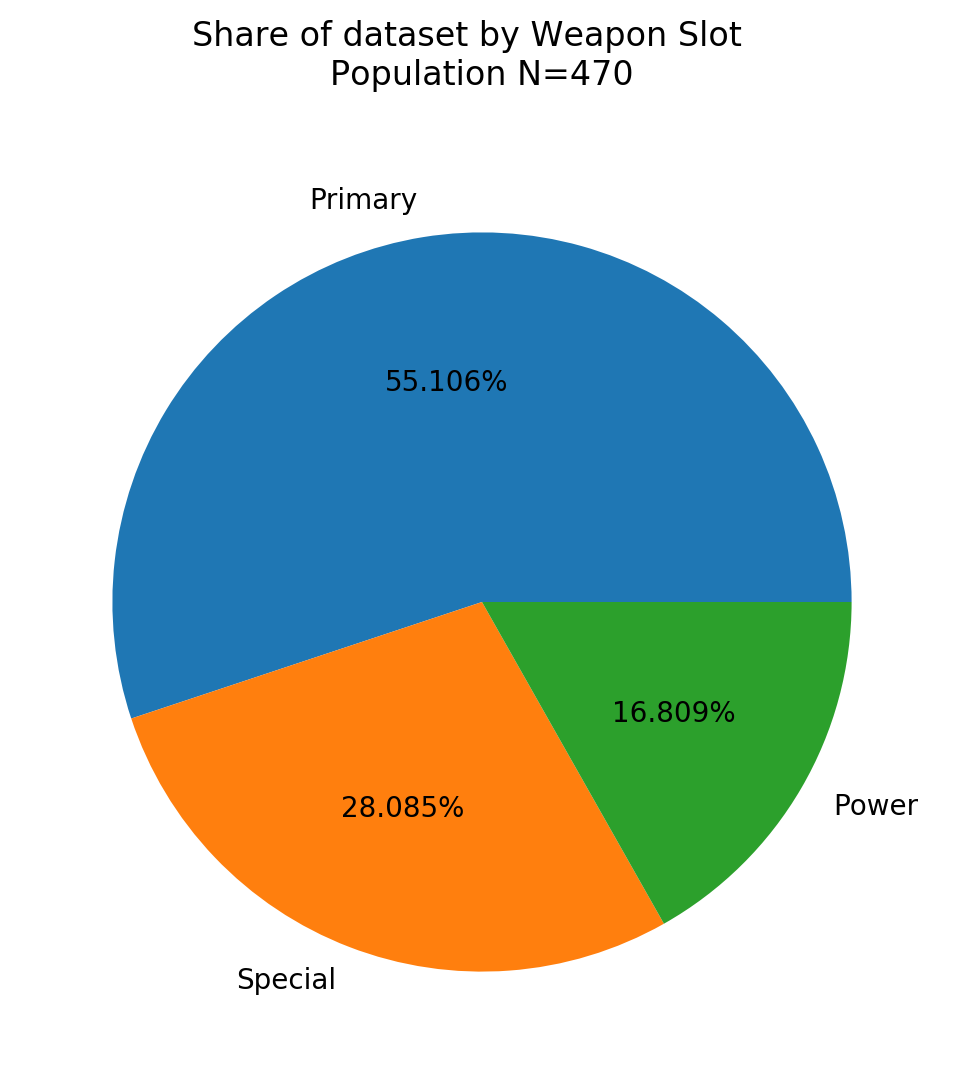

In [6]:

plt.suptitle('Weapon Type size in data corpus')
plt.title('Population N={} unique items\n'.format(df.shape[0]))
weapon_type_counter = Counter(df['Weapon Type'])
plt.pie(weapon_type_counter.values(), labels=weapon_type_counter.keys(), autopct='%.2f%%', pctdistance=1.2, labeldistance=1.35)
plt.show()

plt.suptitle('Weapon Popularity Share by Weapon Type')
plt.title('Population N={} games\n'.format(len(gameSet)))
pop_by_type = df.groupby('Weapon Type')['Global Usage Rate (%)']
#print(pop_by_type)
plt.pie(pop_by_type.sum(), labels=pop_by_type.sum().index, autopct='%.2f%%' , pctdistance=1.2, labeldistance=1.35, startangle=45+90)
plt.show()

plt.suptitle('Share of dataset by Weapon Slot')
plt.title('Population N={}\n'.format(df.shape[0]))
ammo_type_counter = Counter(df['Slot'])
plt.pie(ammo_type_counter.values(), labels=ammo_type_counter.keys(), autopct='%.3f%%')
plt.show()

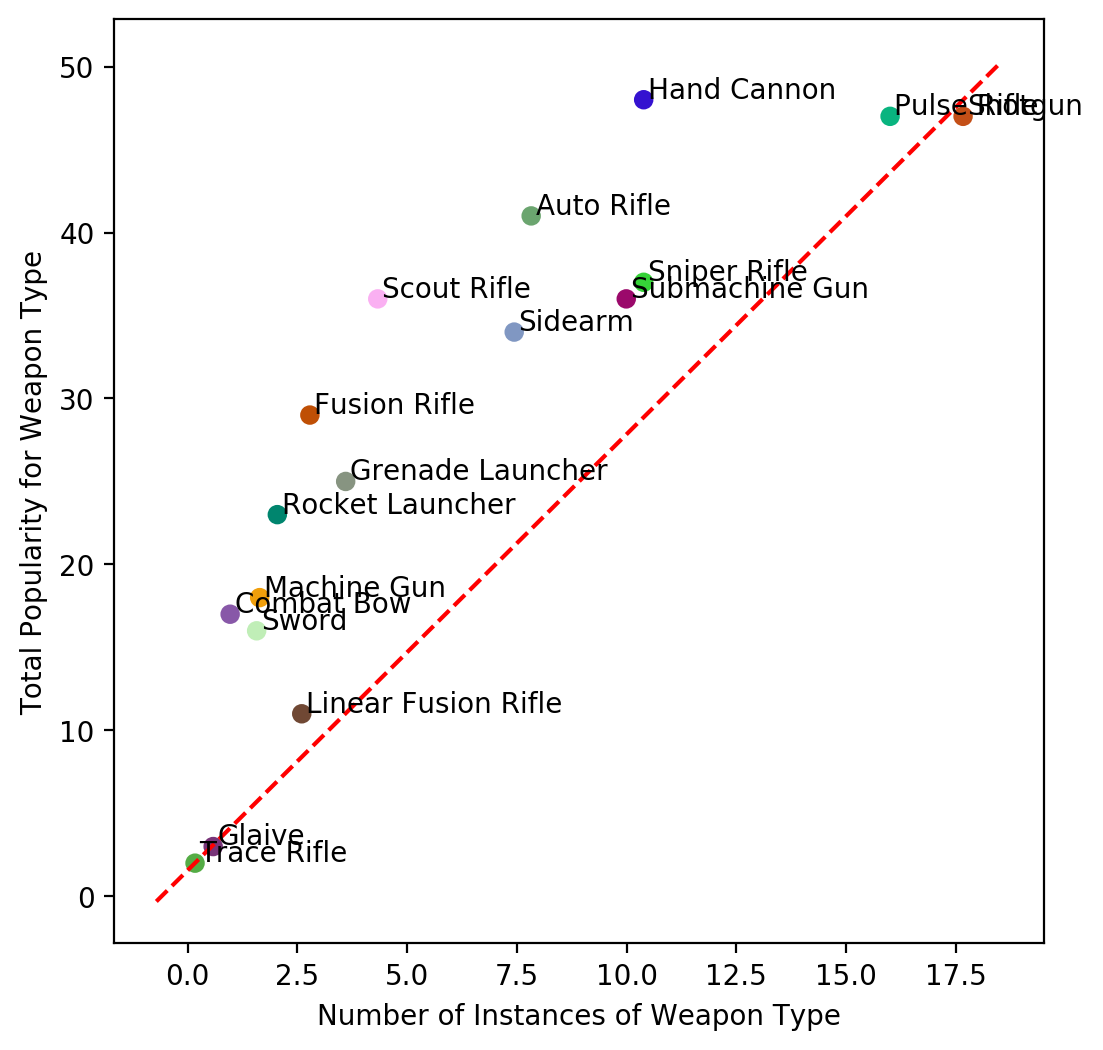

In [7]:
pop_by_type = df.groupby('Weapon Type')['Global Usage Rate (%)'].sum()
size_by_type= df.groupby('Weapon Type').size()


plt.scatter(pop_by_type, size_by_type, c=np.random.rand(len(pop_by_type), 3))
[plt.text(x+0.1, y+0.1, label) for x, y, label in zip(pop_by_type, size_by_type, pop_by_type.index)]
plt.plot(plt.xlim(), plt.ylim(), linestyle='--', color='red')

plt.xlabel('Number of Instances of Weapon Type')
plt.ylabel('Total Popularity for Weapon Type')
plt.show()

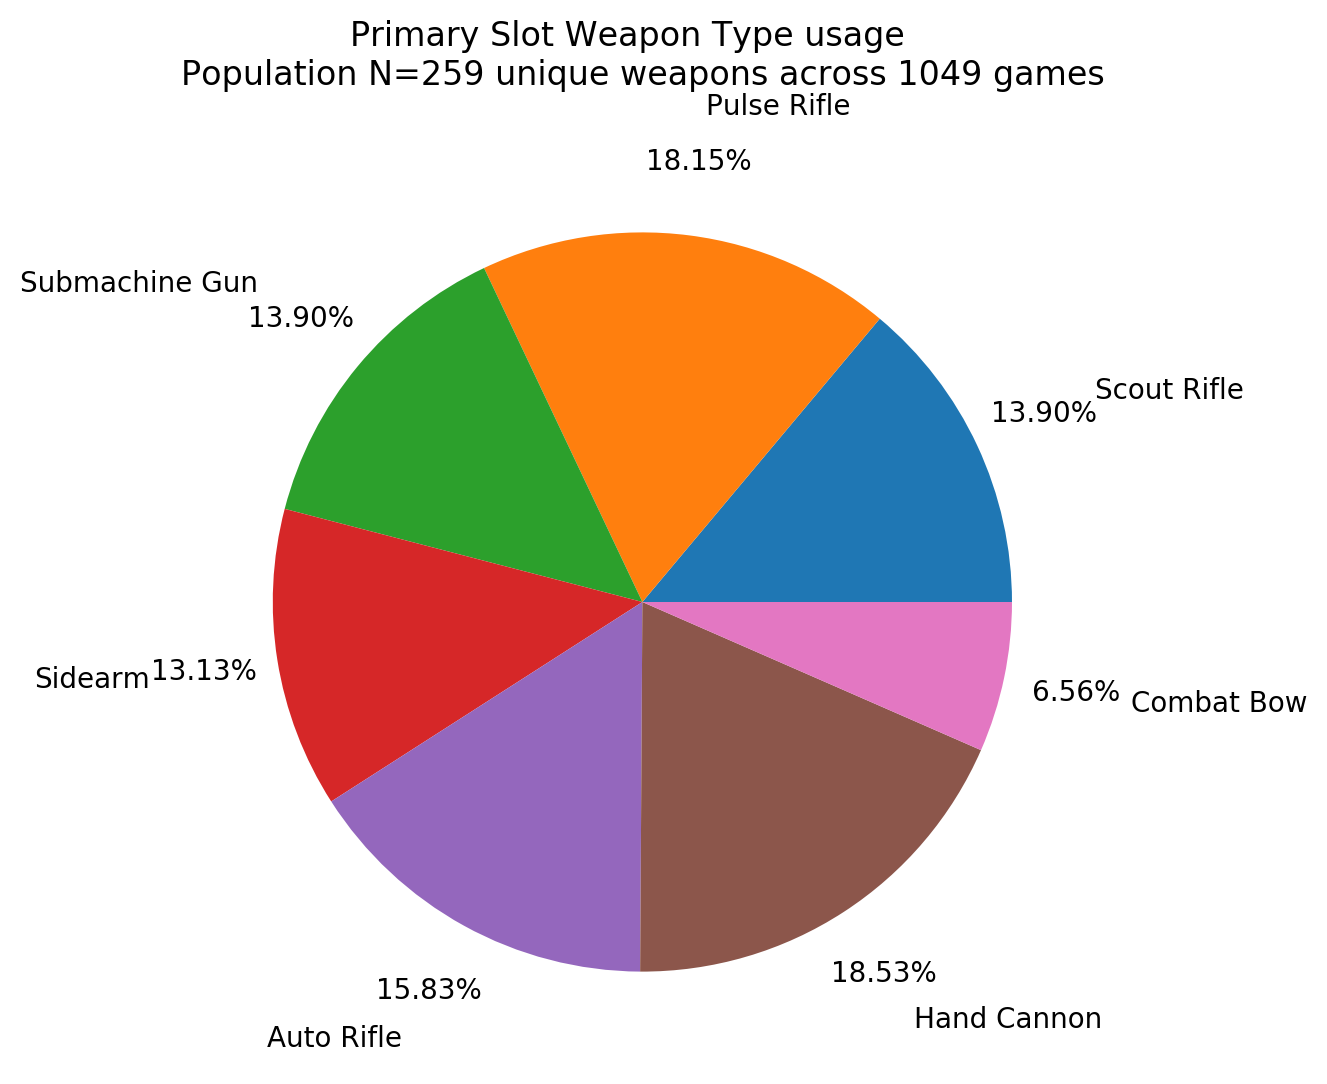

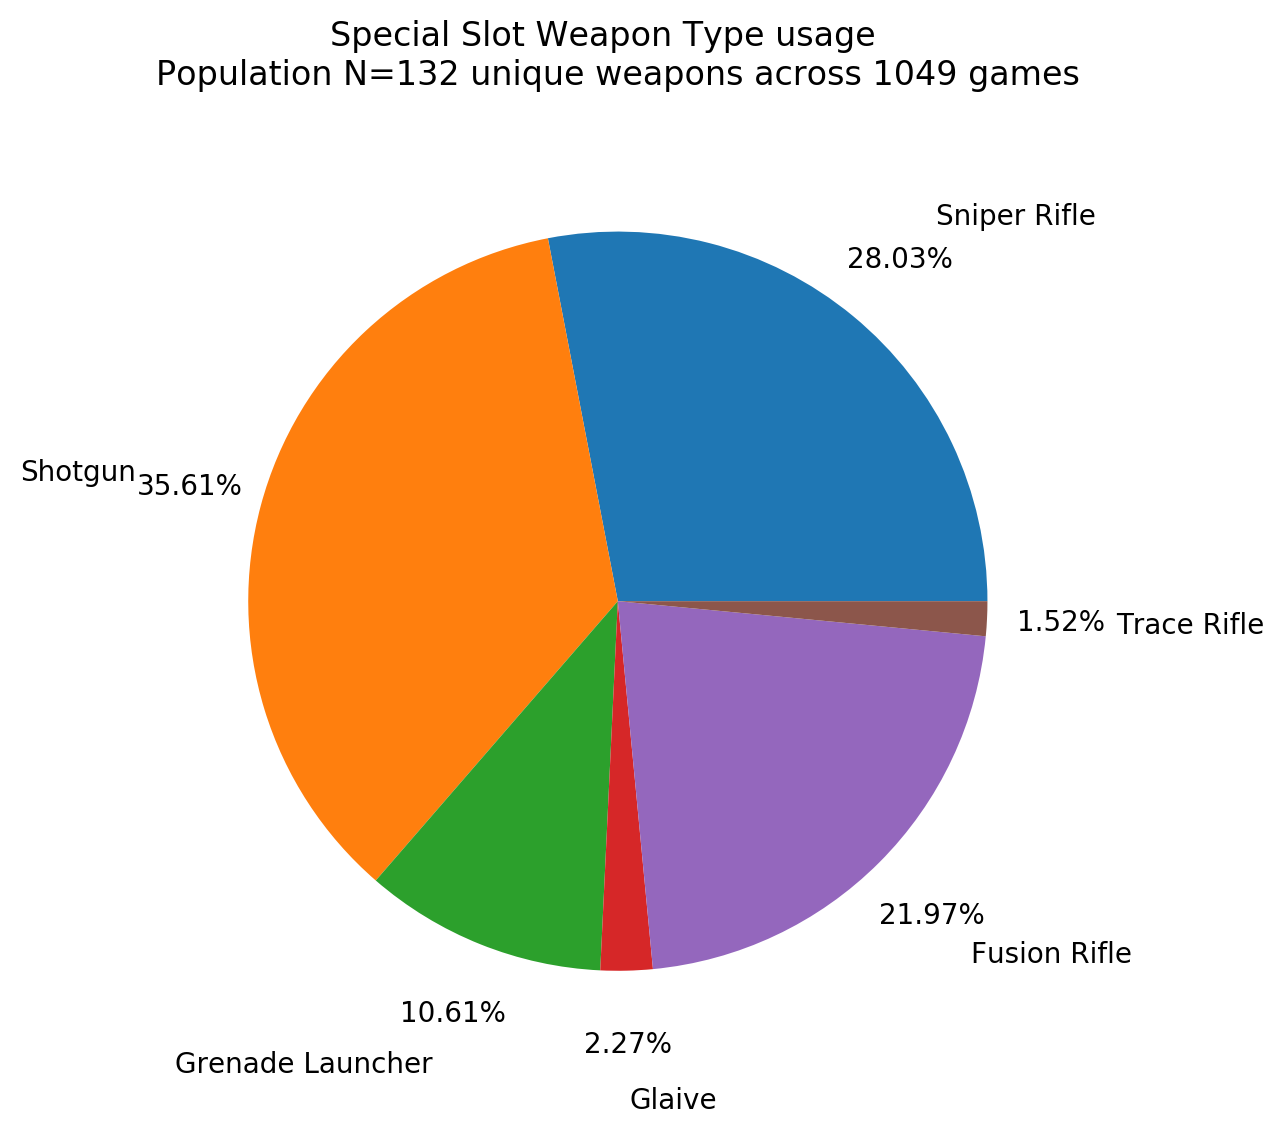

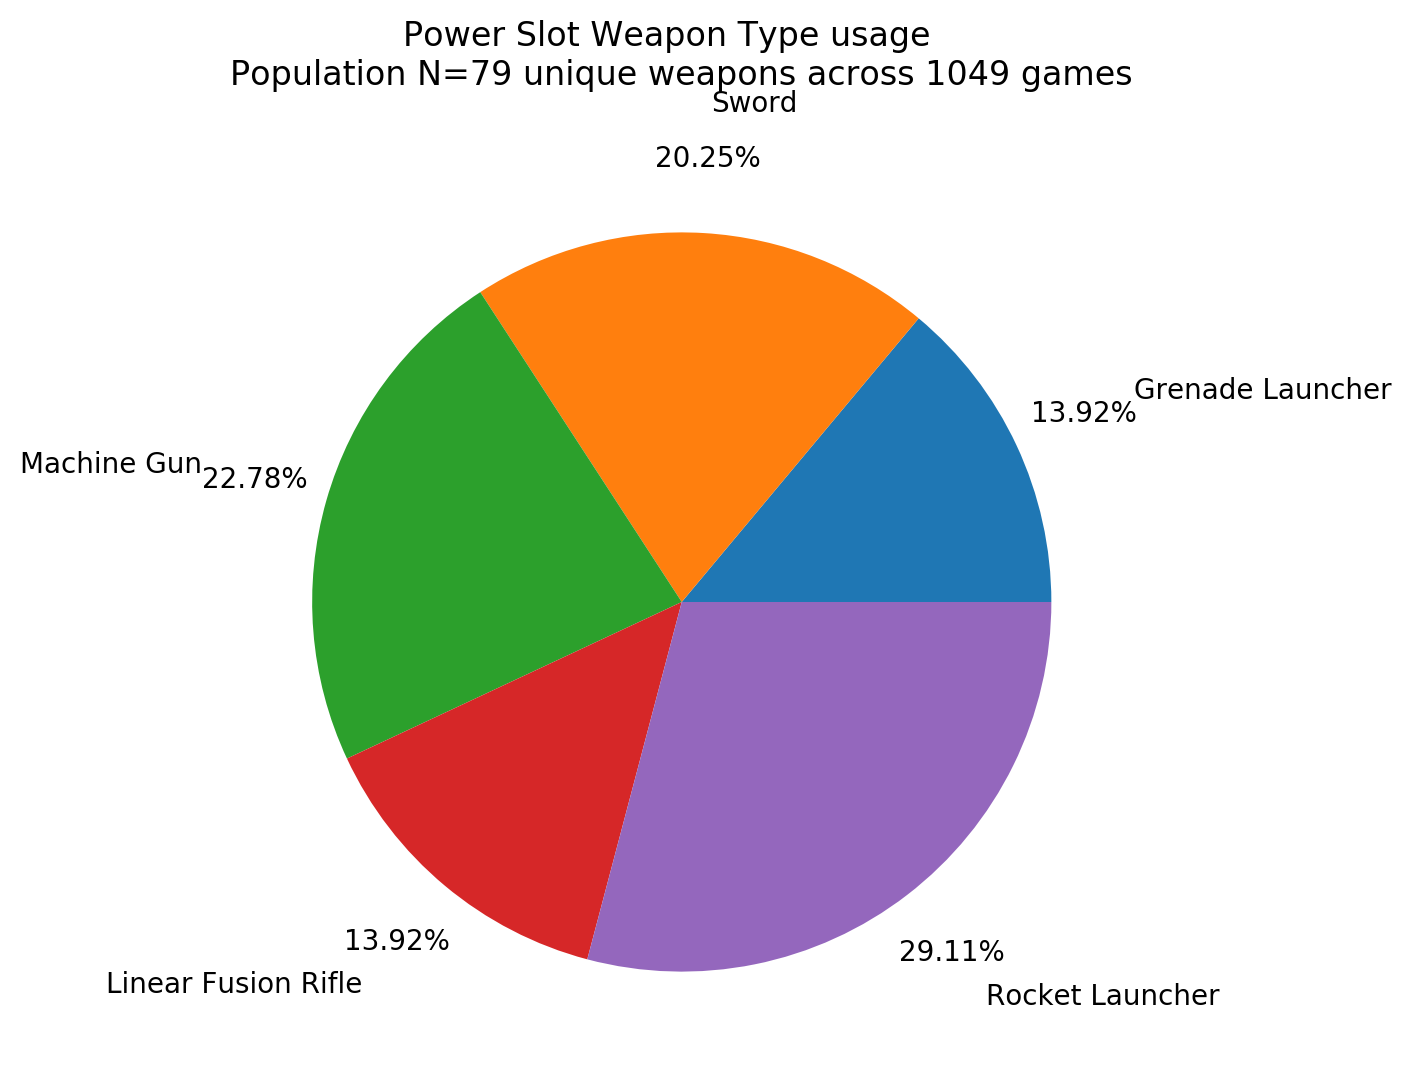

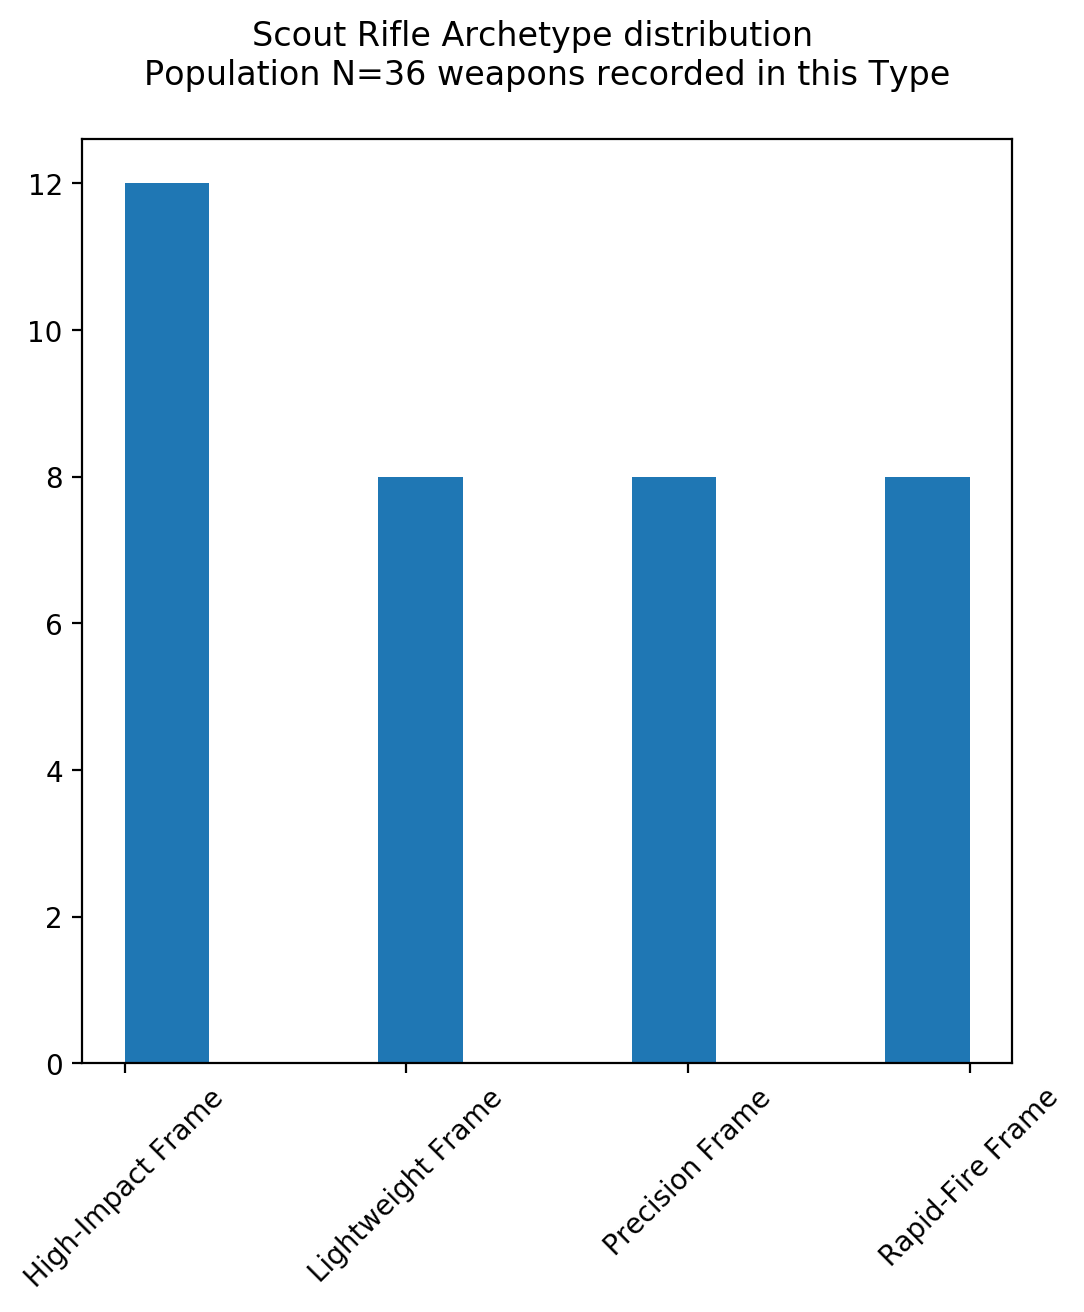

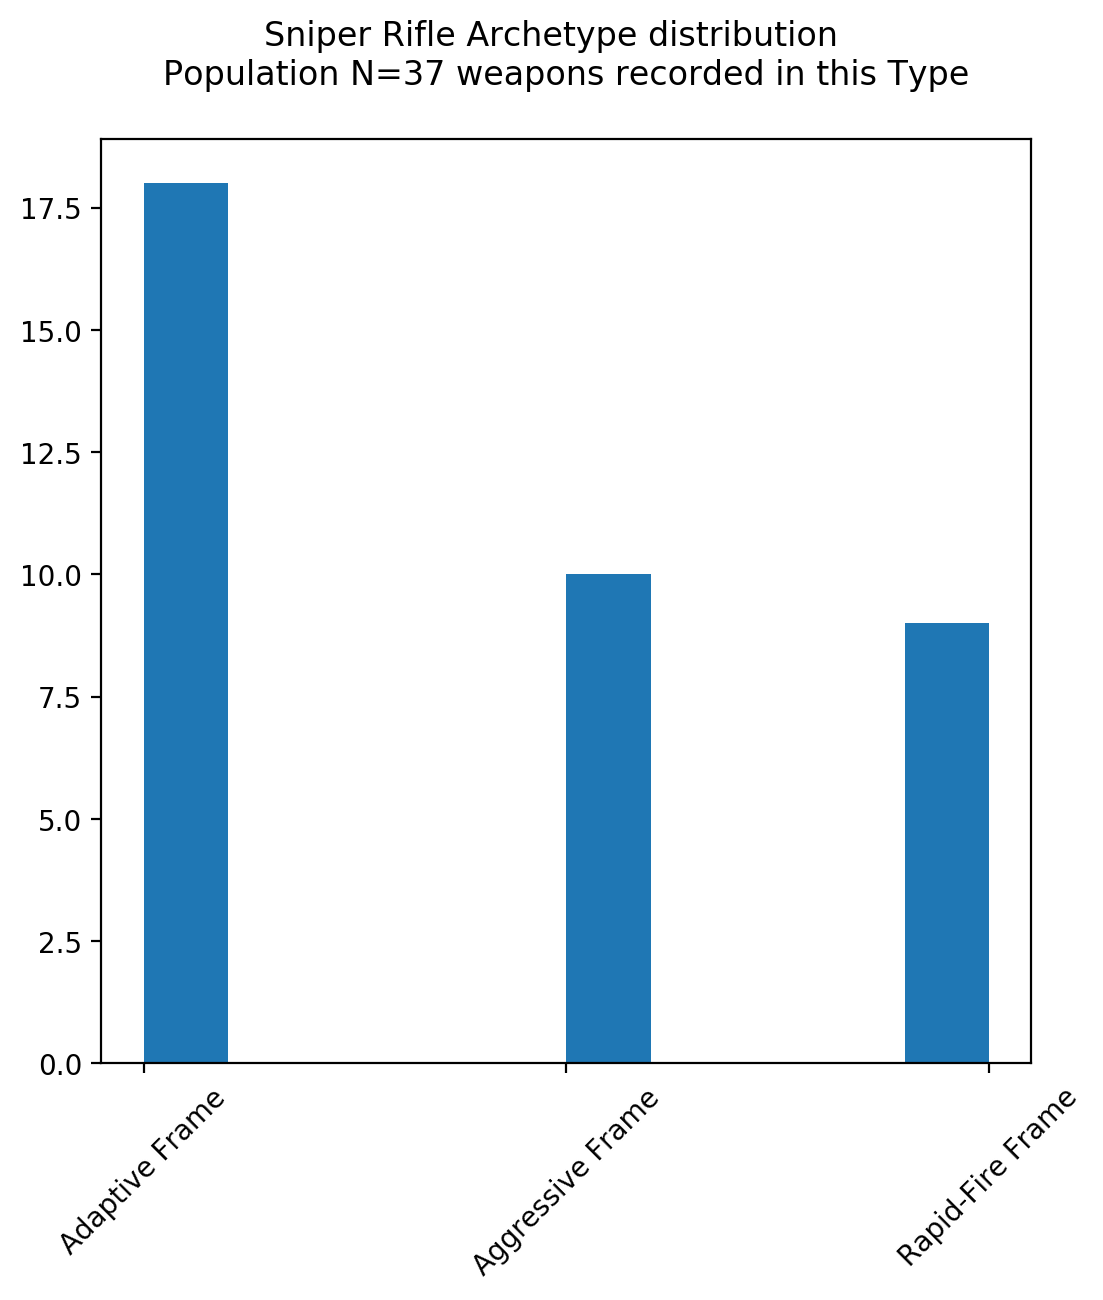

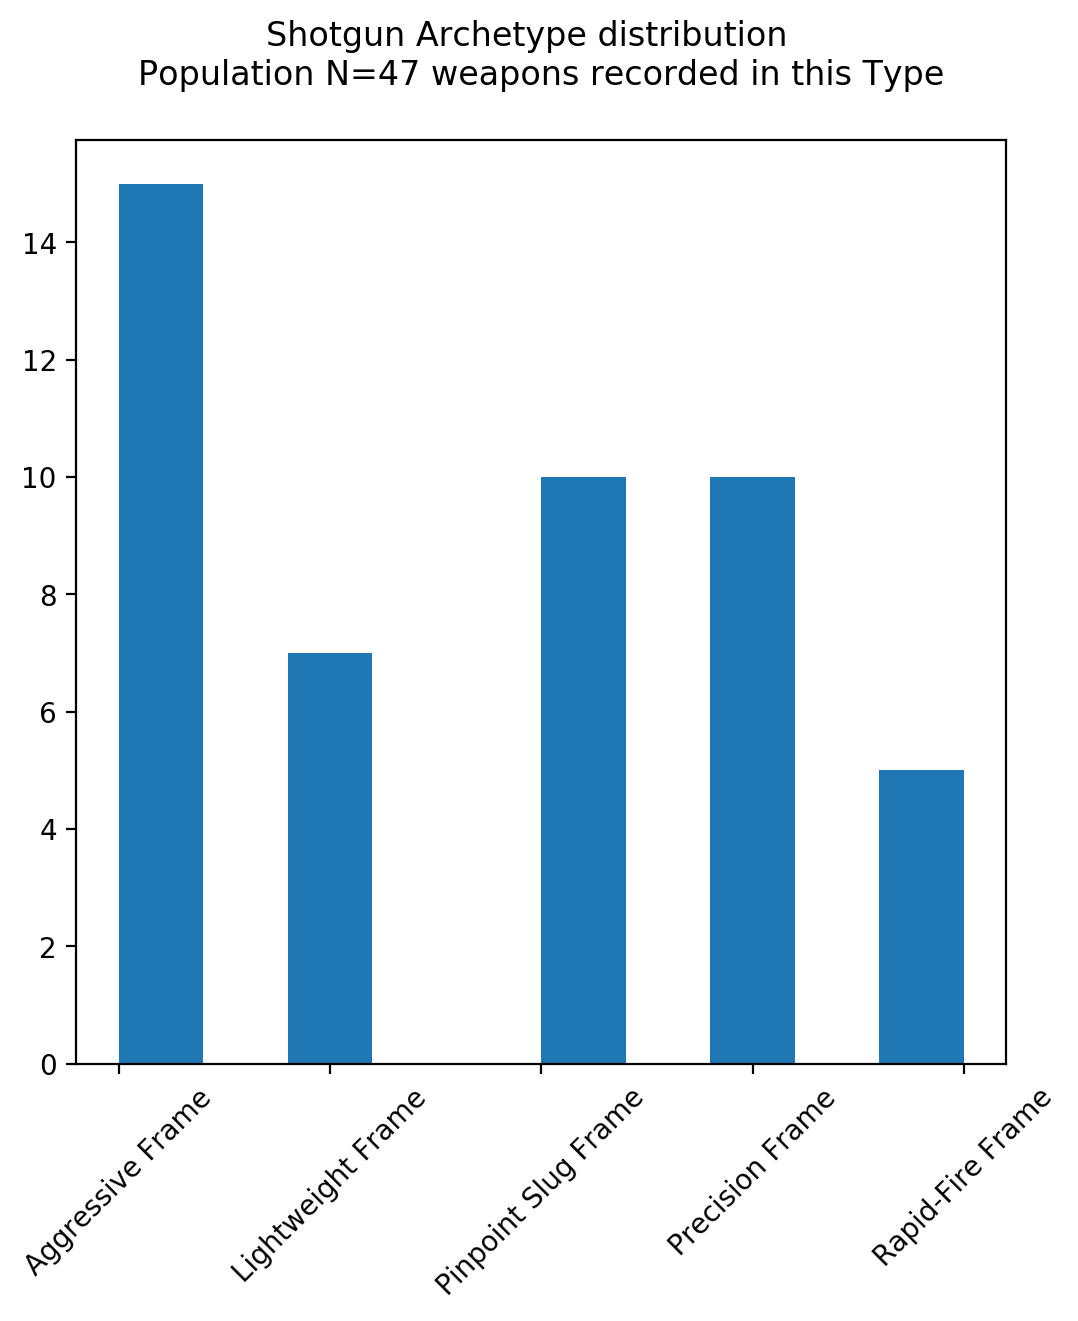

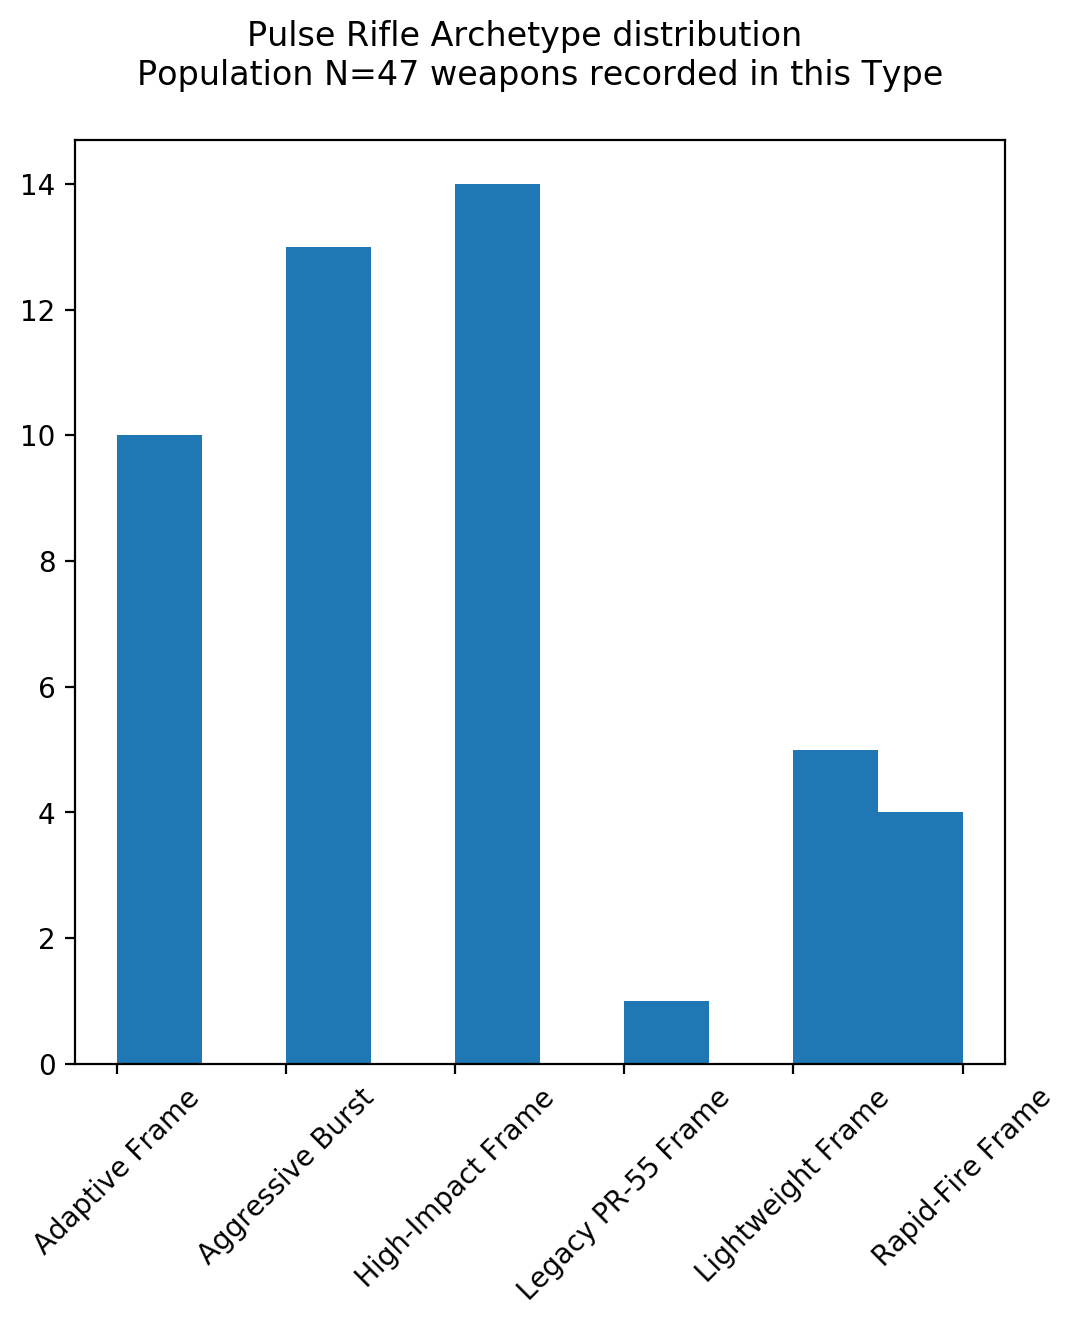

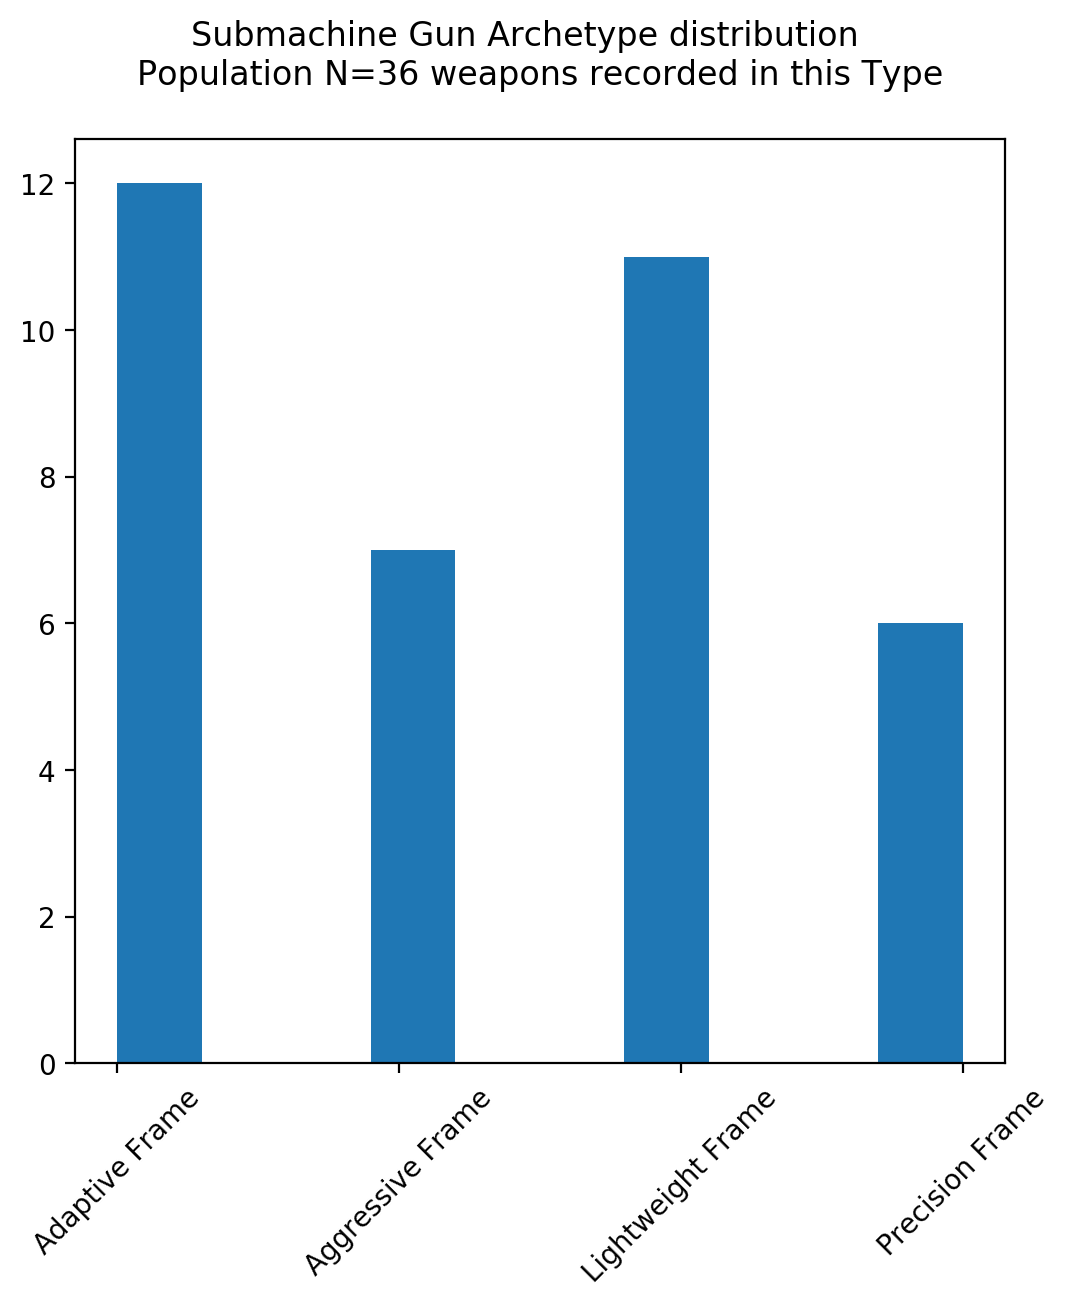

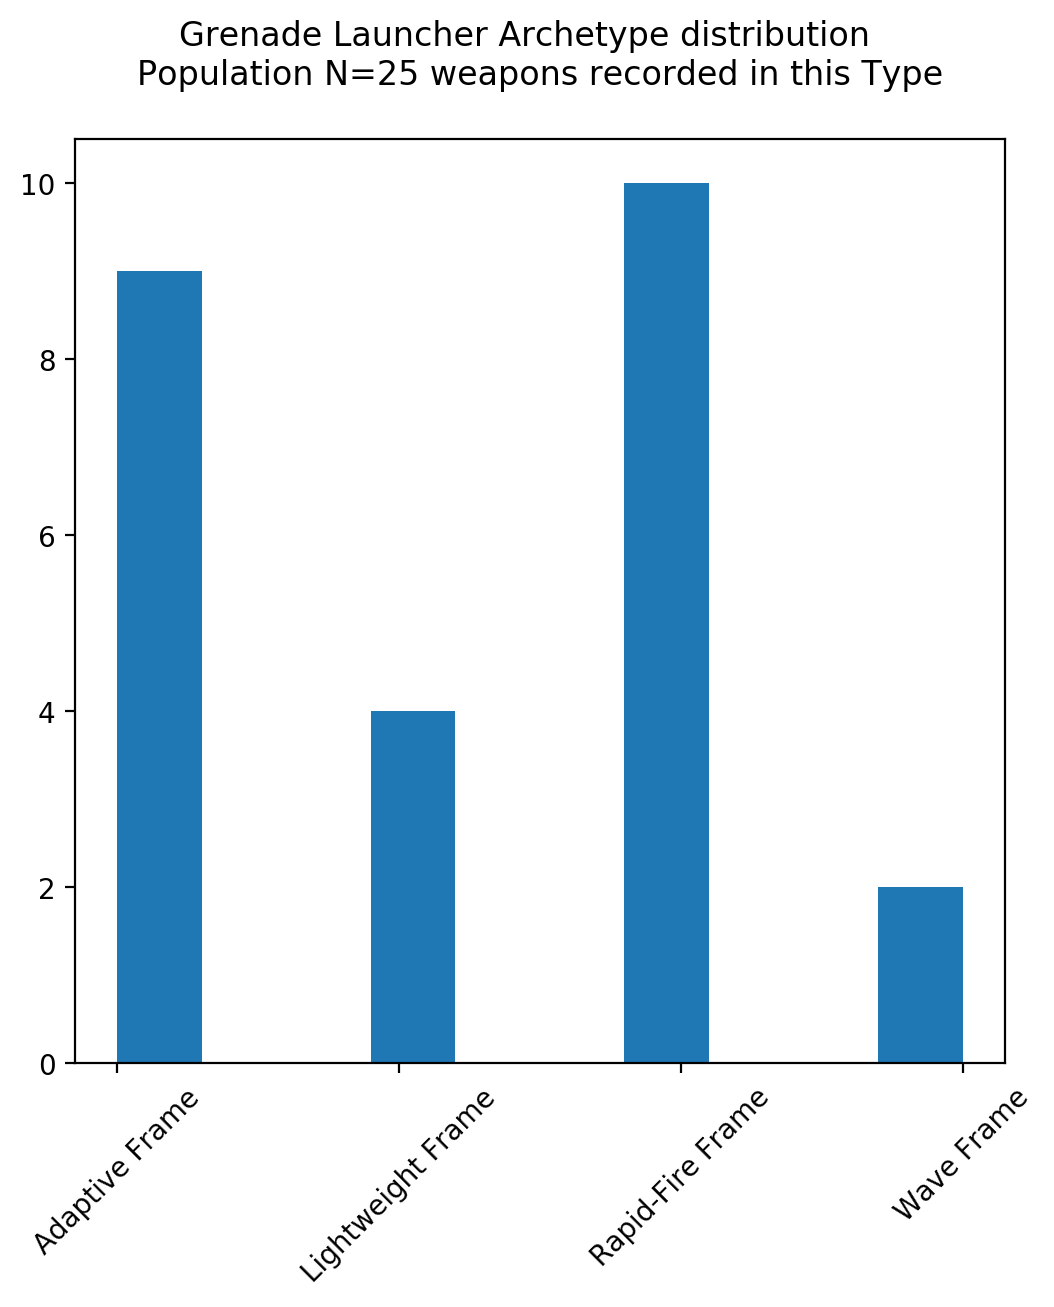

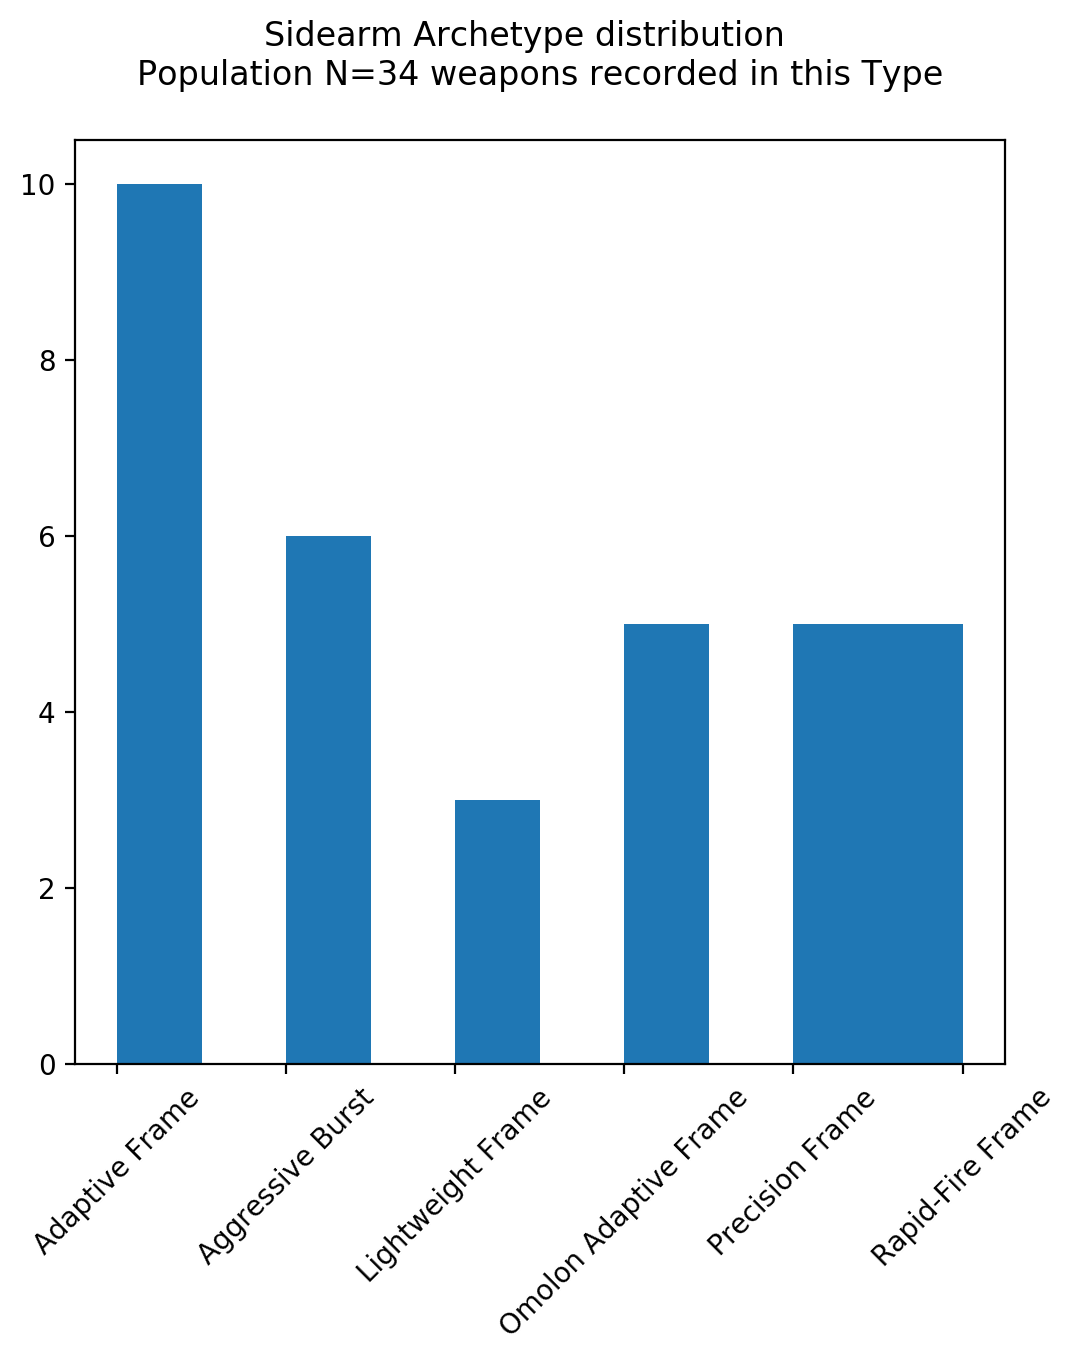

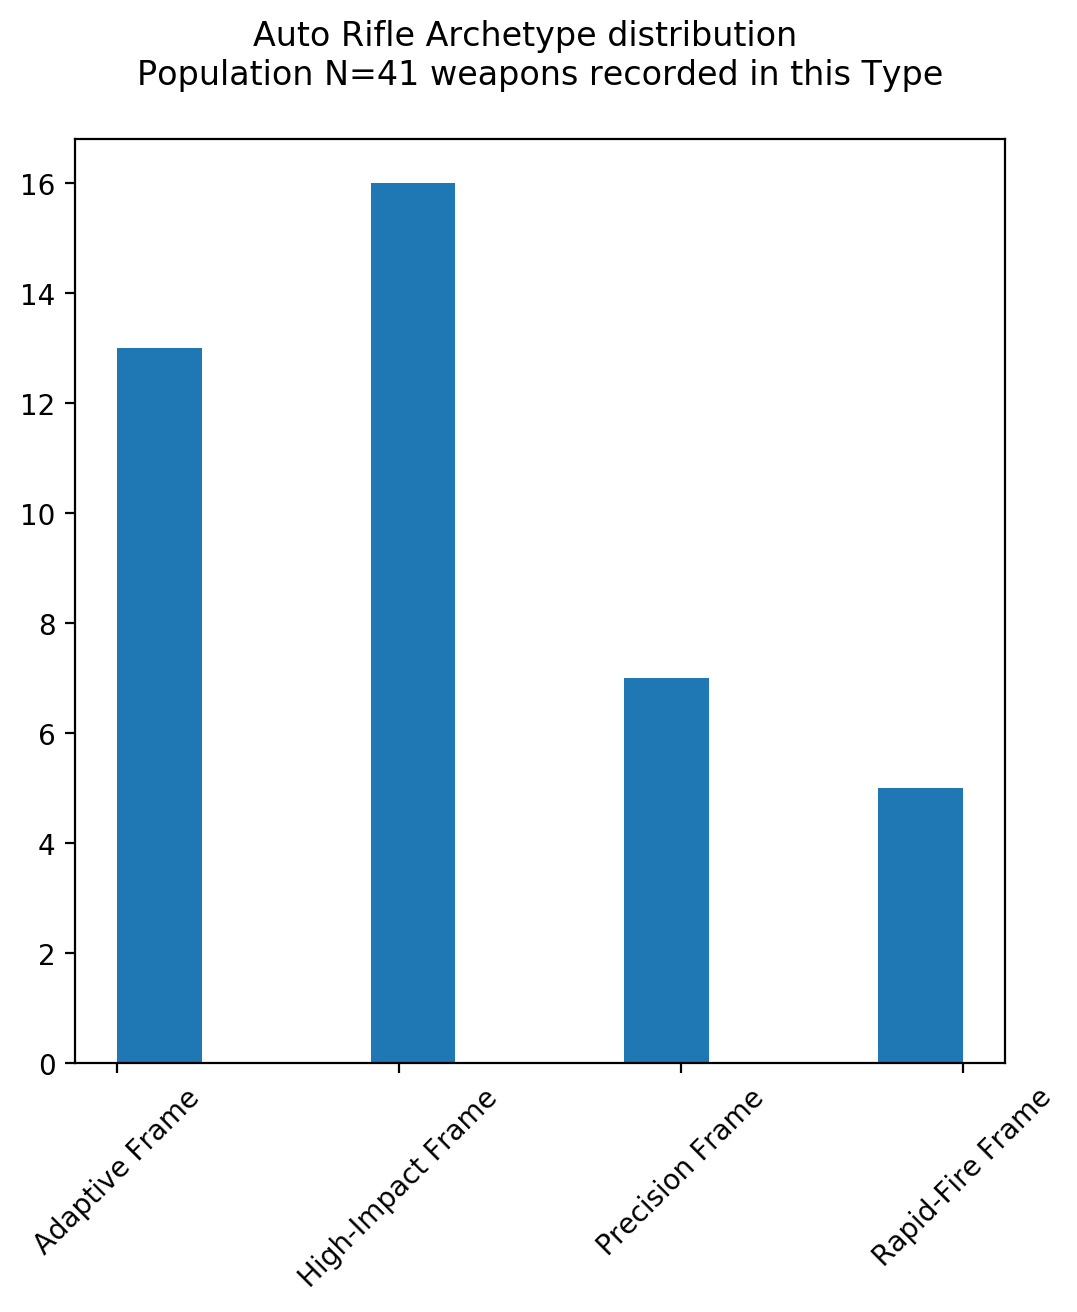

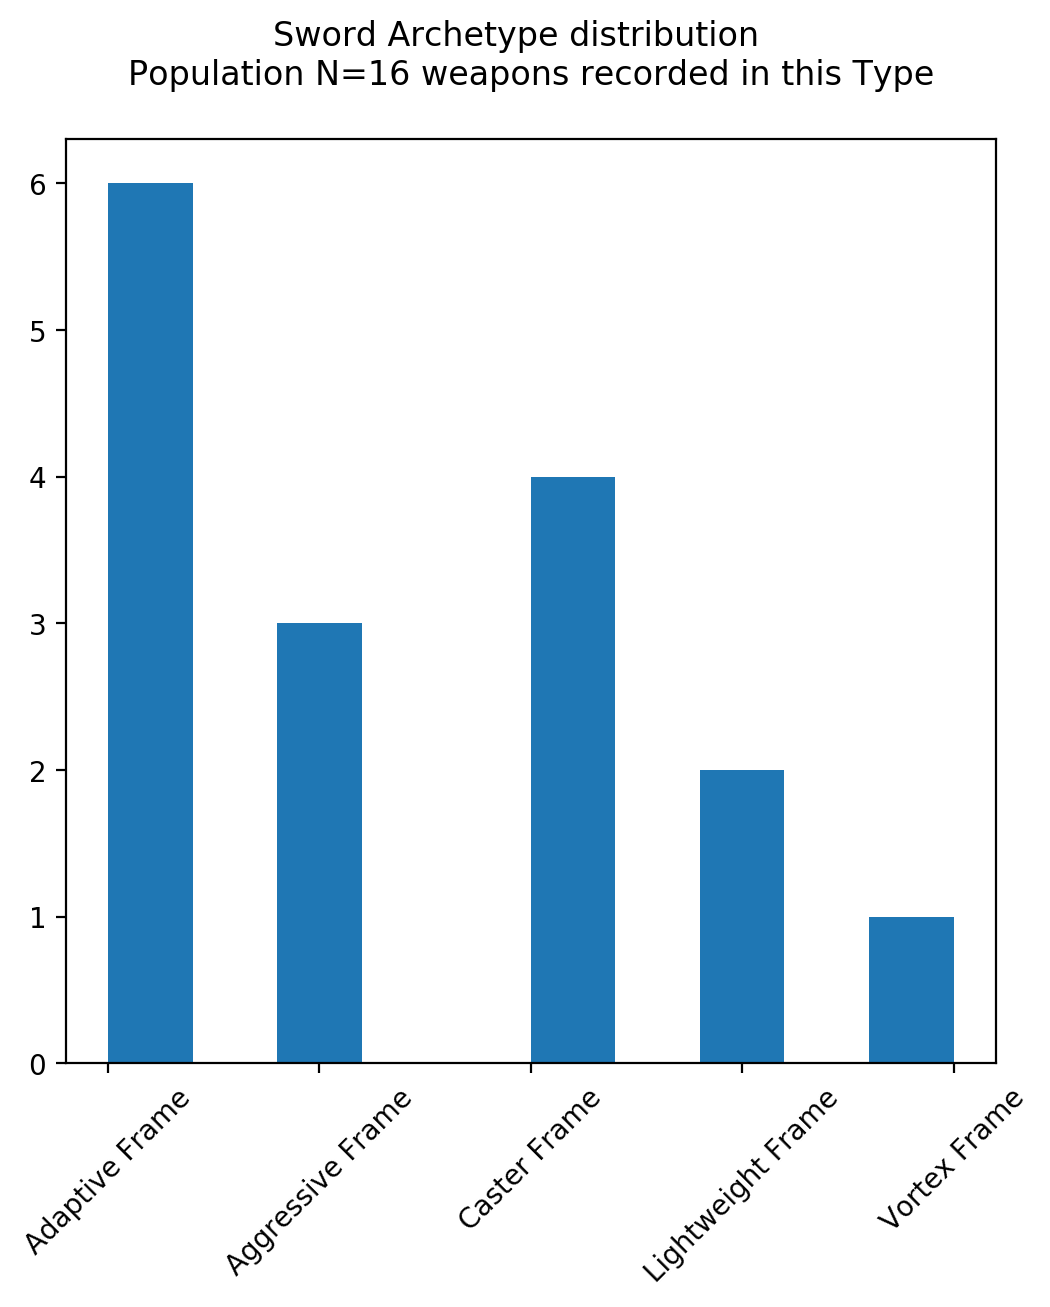

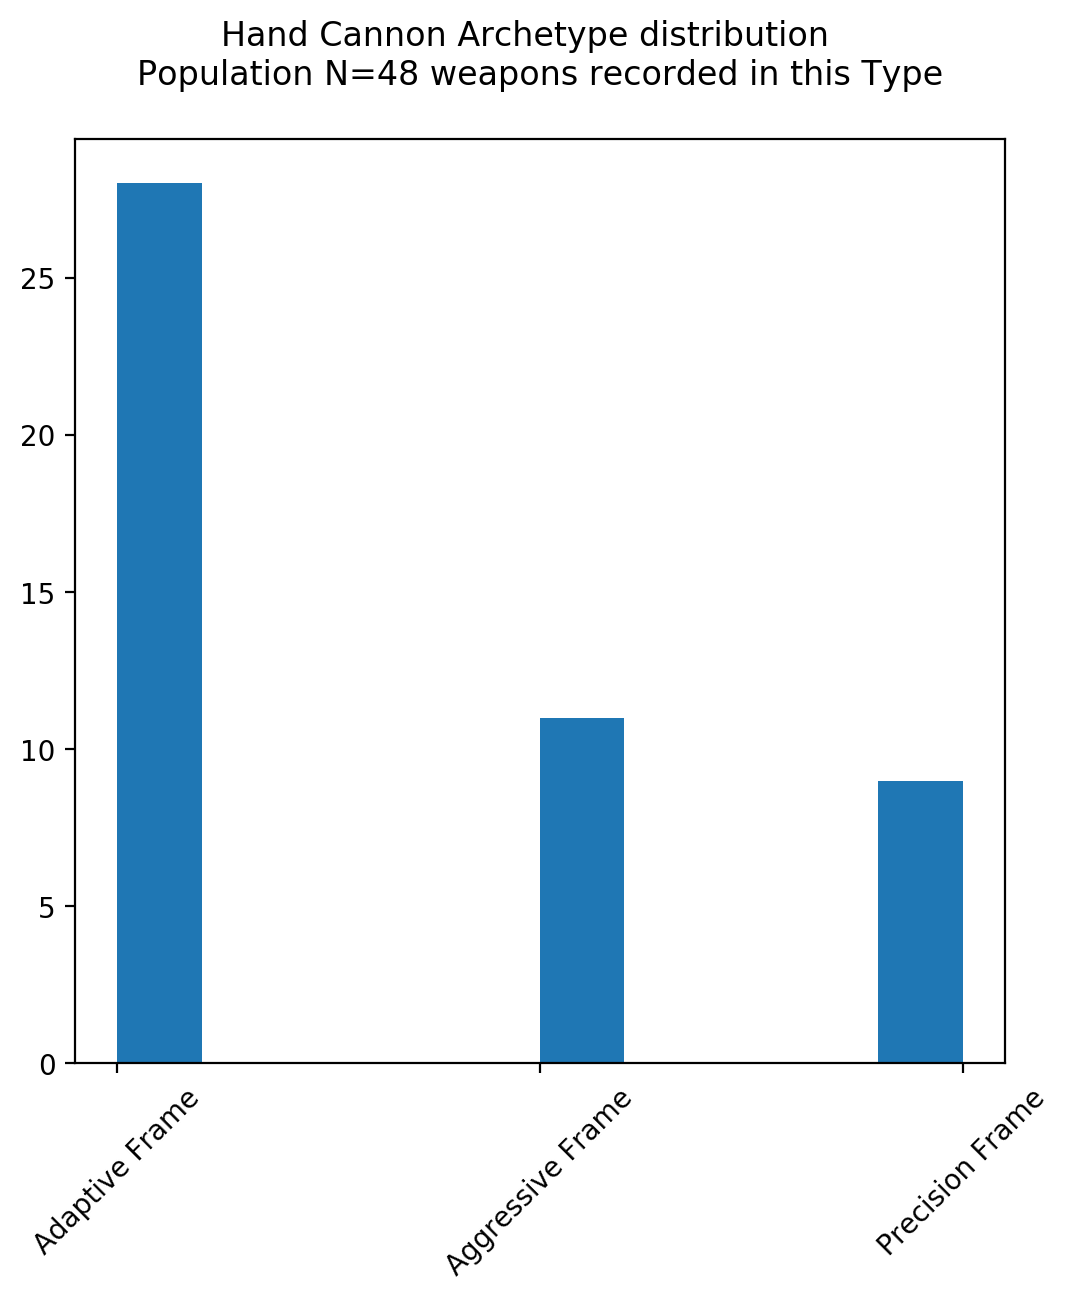

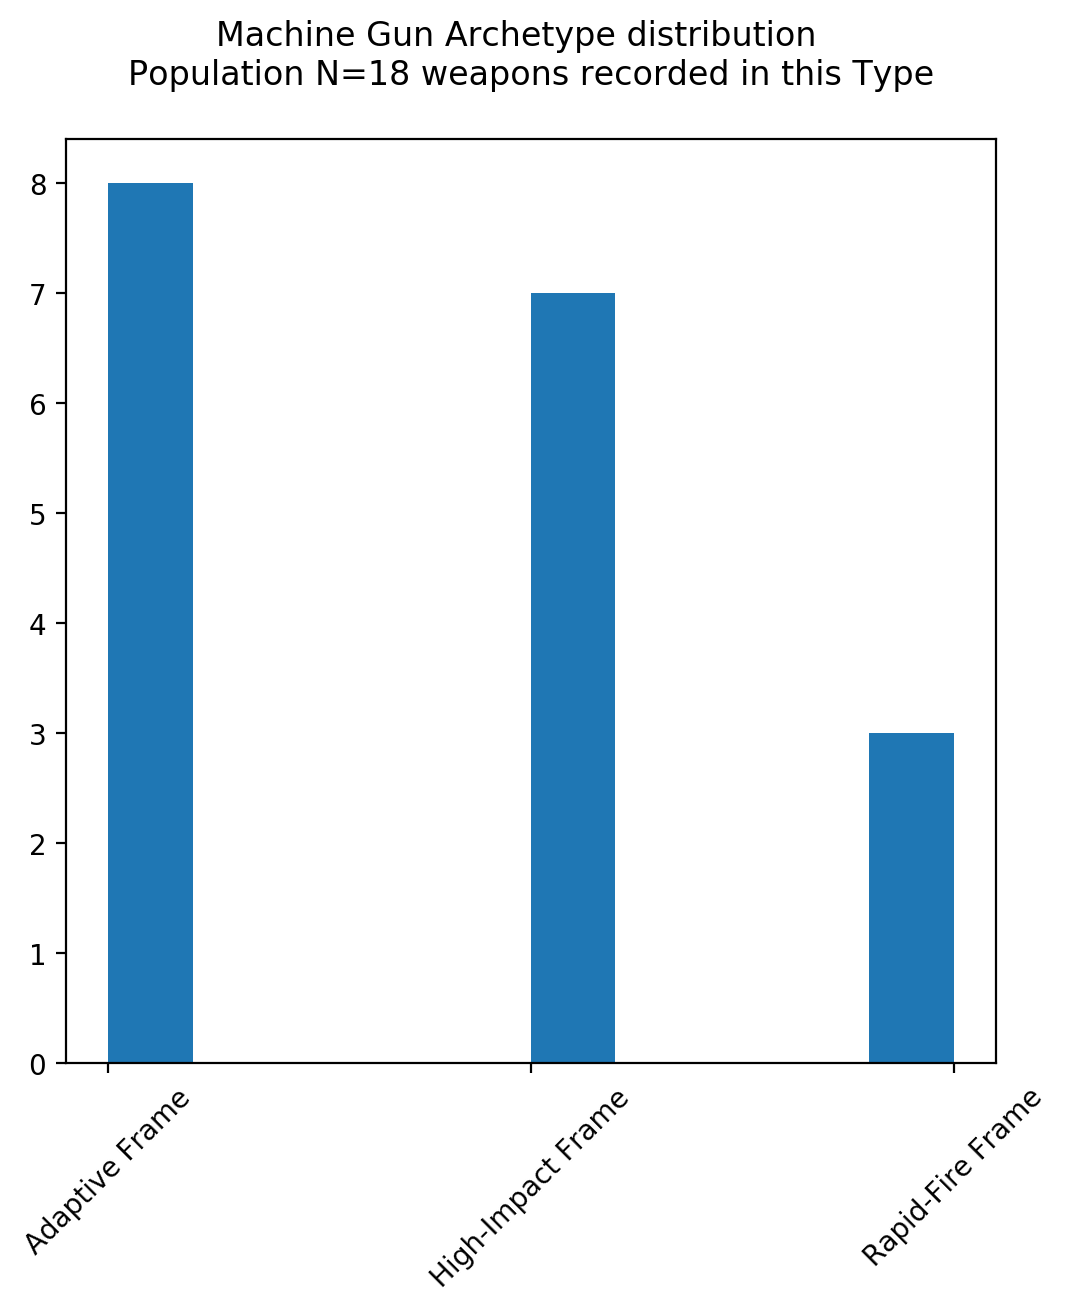

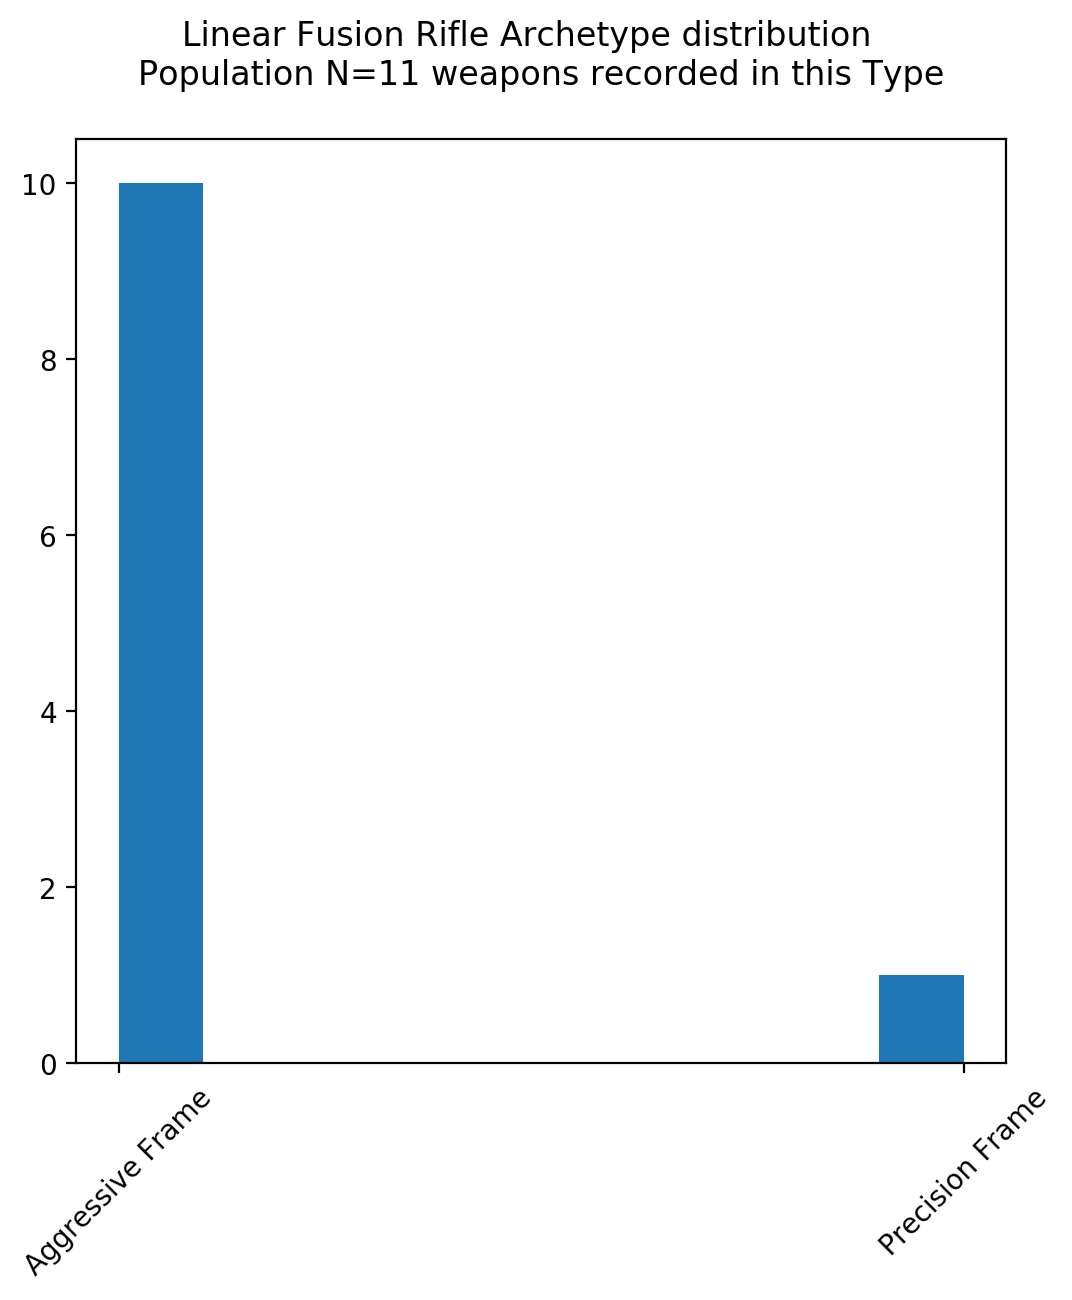

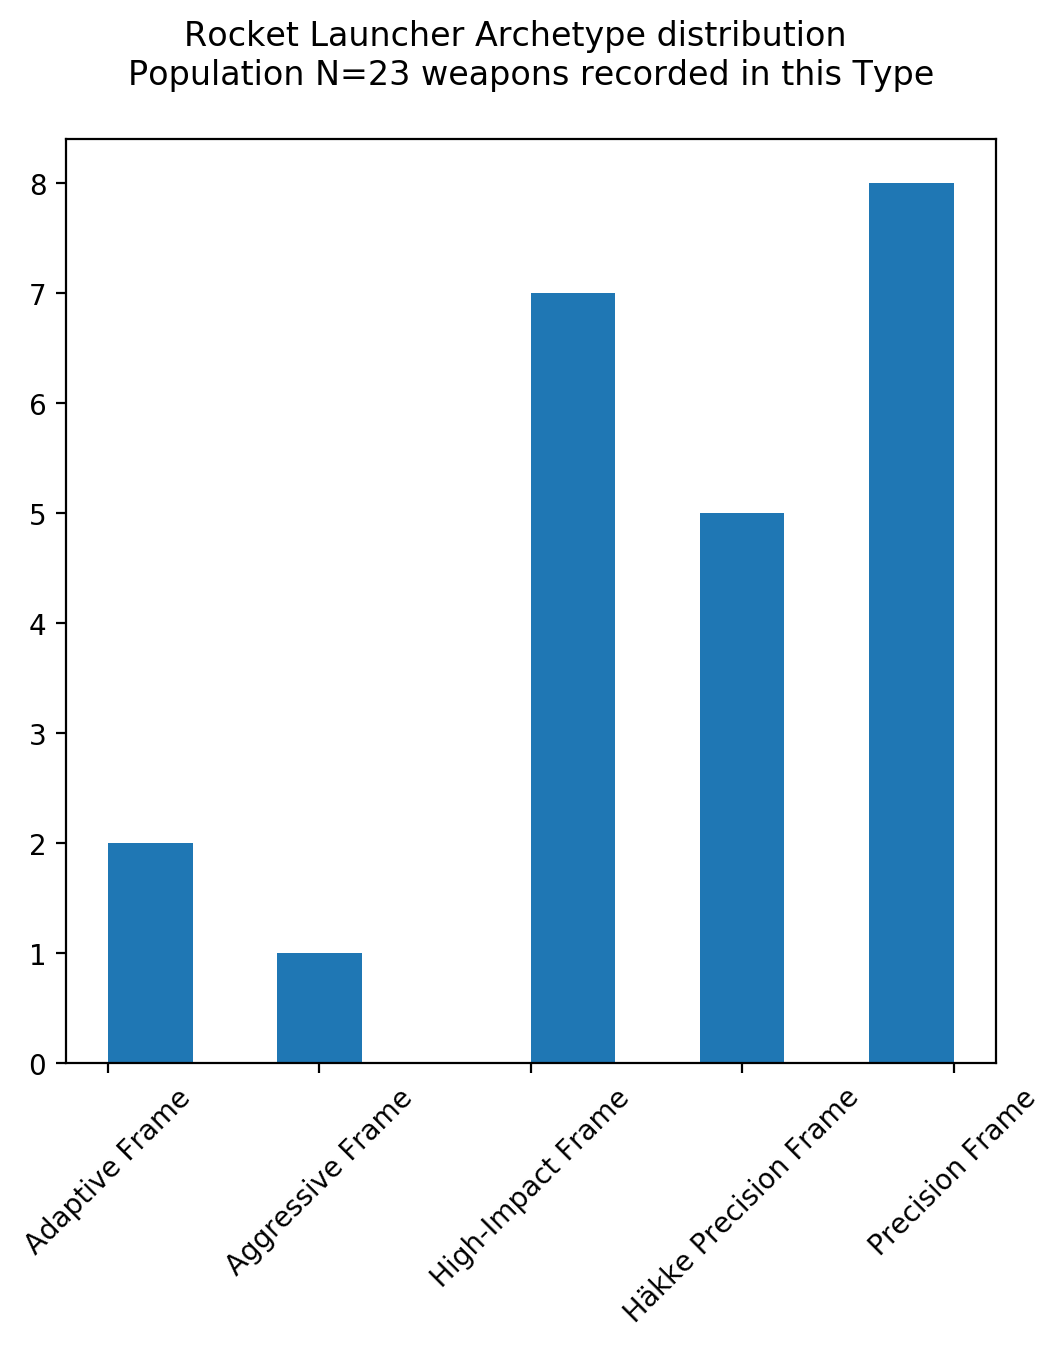

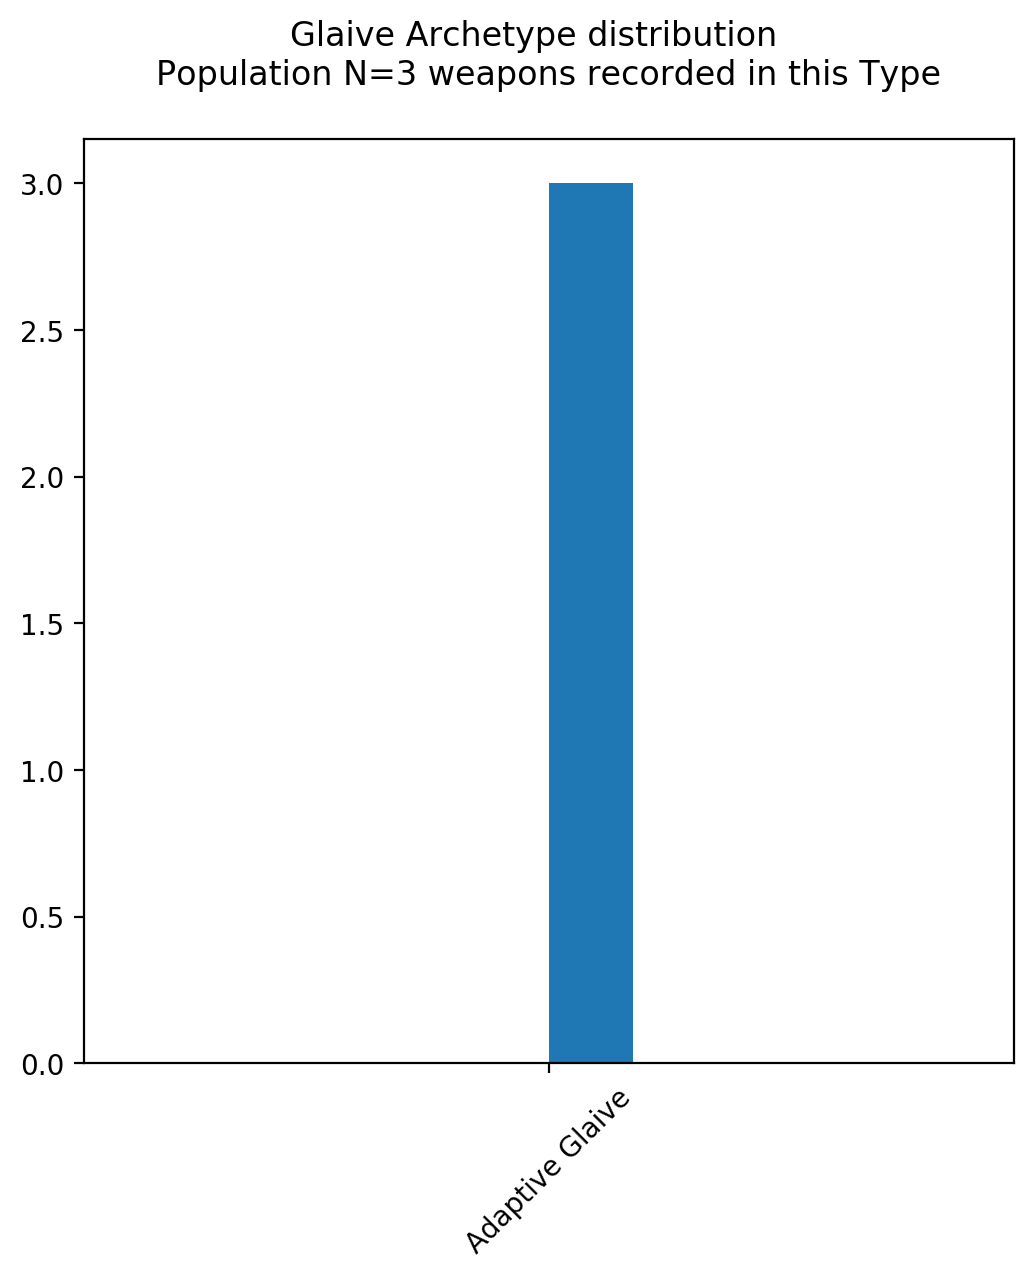

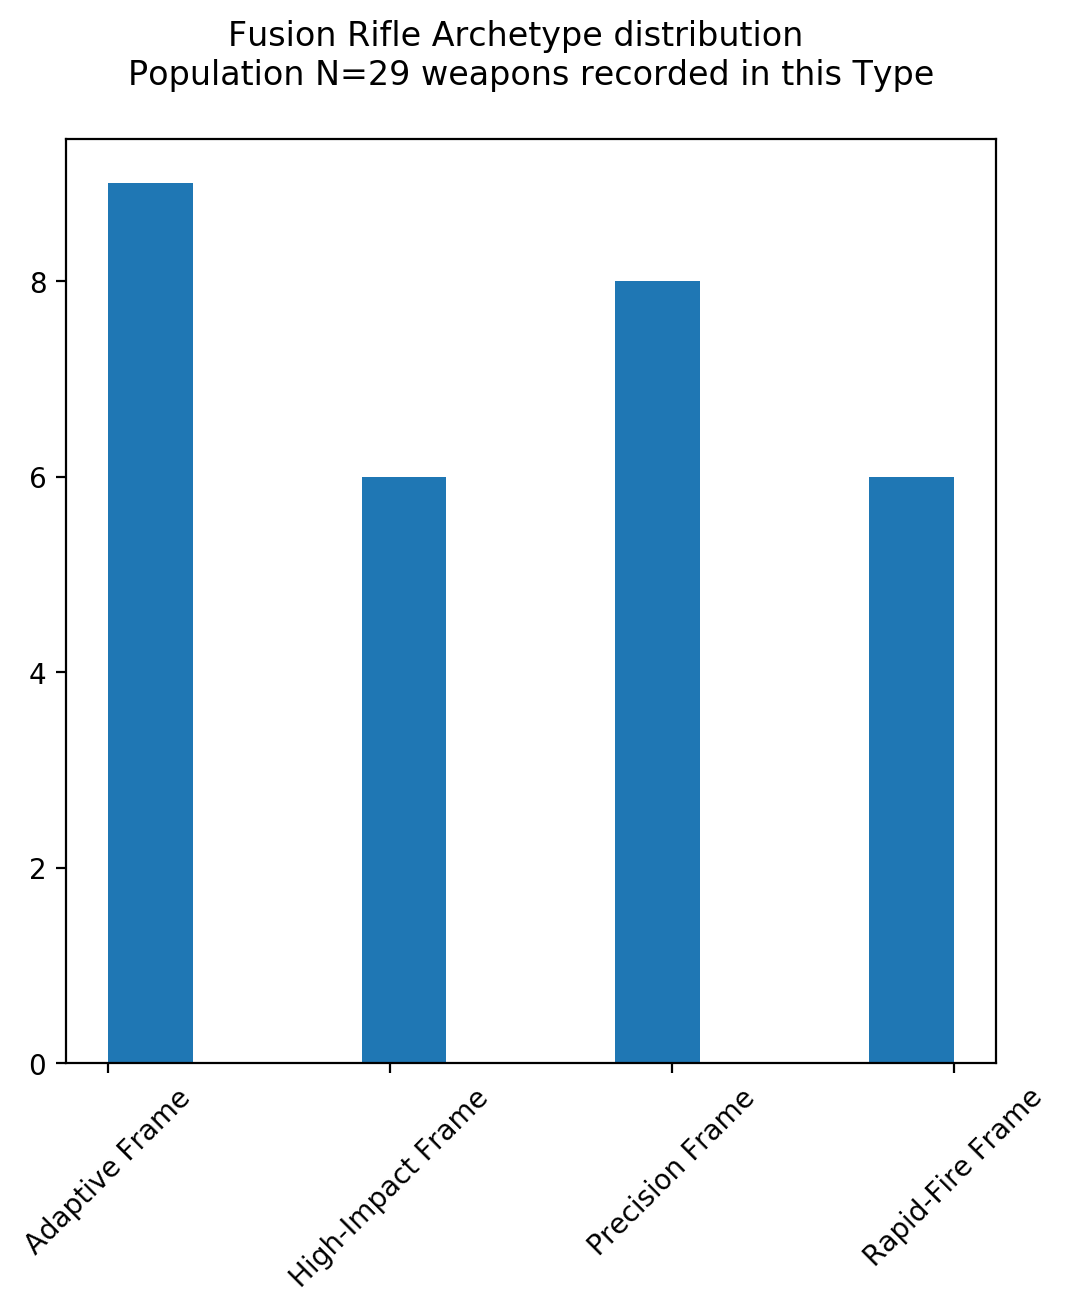

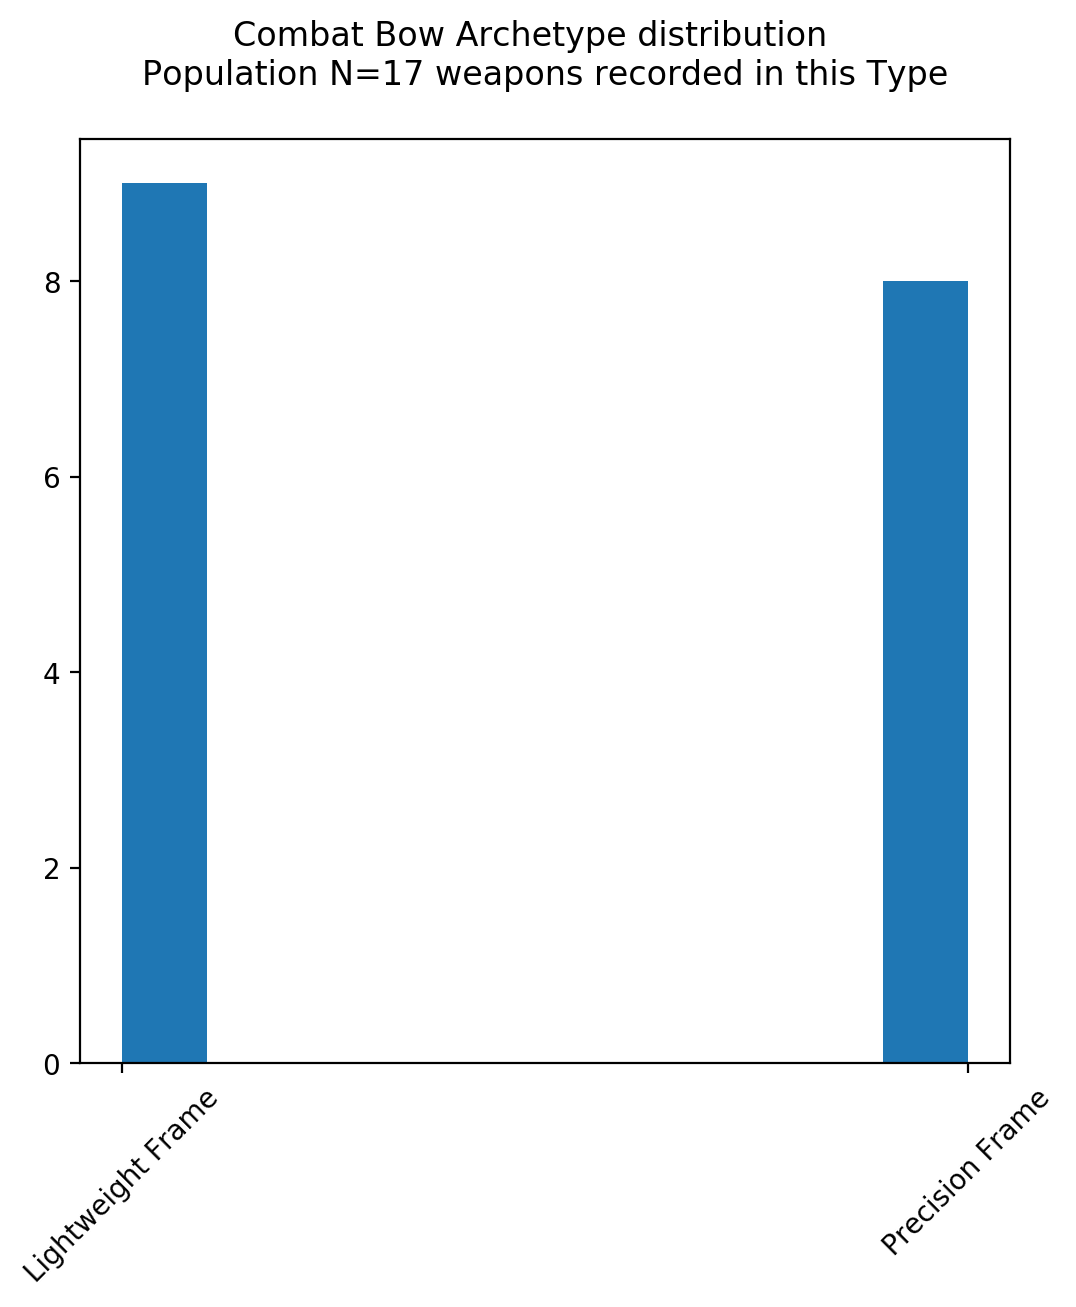

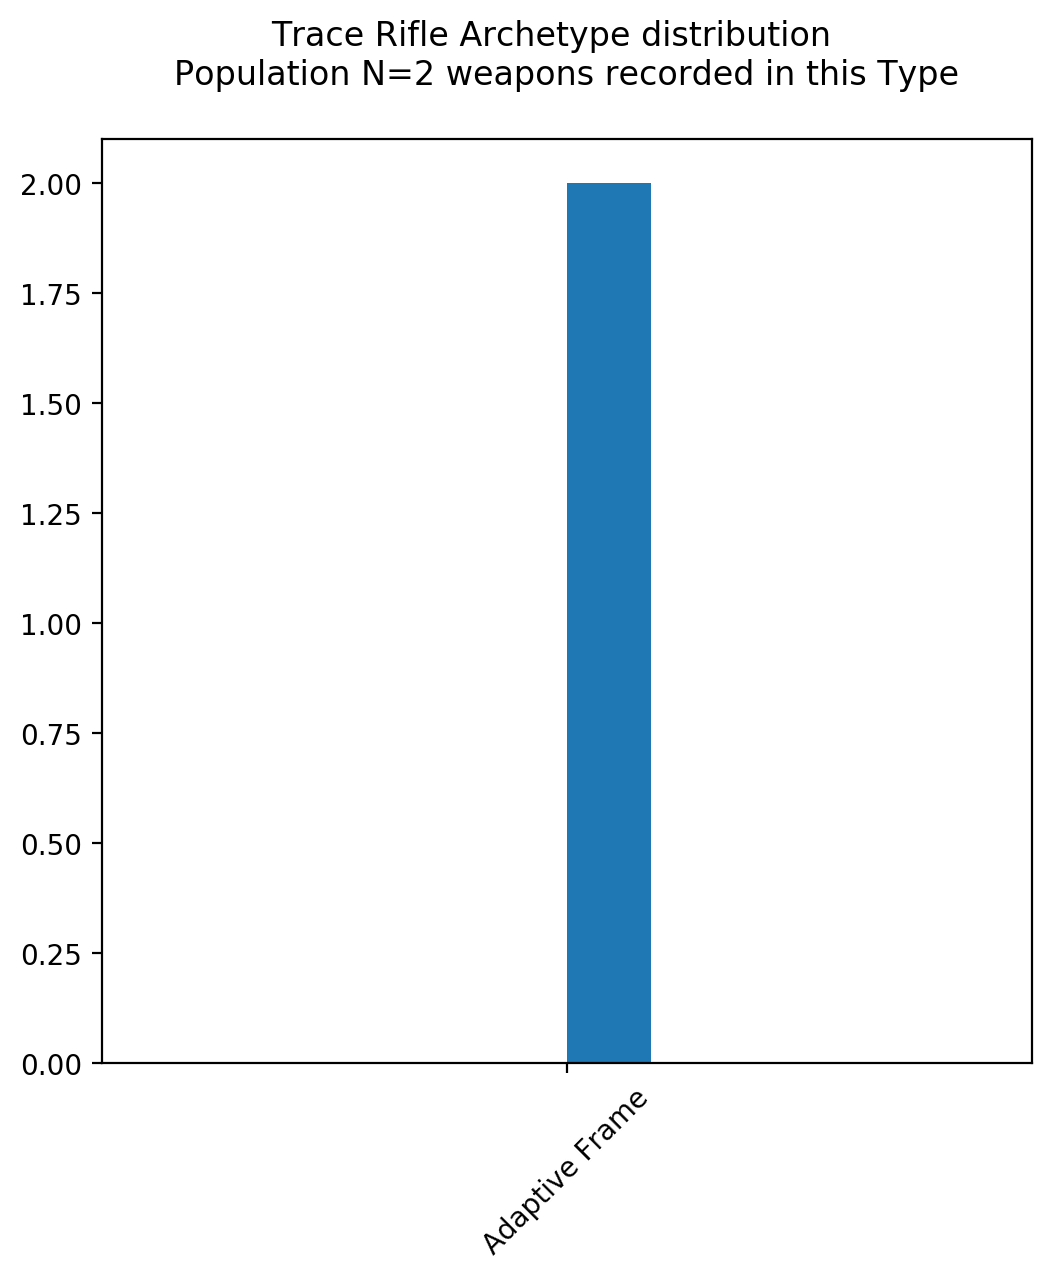

In [8]:
for slot in df['Slot'].unique():
    subset_by_slot = df.loc[df['Slot'] == slot]
    weapon_type_counter = Counter(subset_by_slot['Weapon Type'])
    plt.suptitle('{} Slot Weapon Type usage'.format(slot))
    plt.title('Population N={} unique weapons across {} games\n'.format(len(subset_by_slot), len(gameSet)))
    plt.pie(weapon_type_counter.values(), labels=weapon_type_counter.keys(), autopct='%.2f%%', pctdistance=1.2, labeldistance=1.35)
    plt.show()

for weaponType in df['Weapon Type'].unique():
    subset_by_slot = df.loc[df['Weapon Type'] == weaponType]
    plt.suptitle('{} Archetype distribution'.format(weaponType))
    plt.title('Population N={} weapons recorded in this Type\n'.format(len(subset_by_slot)))
    plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))
    plt.hist(subset_by_slot['Archetype'], align='mid')
    plt.show()

In [9]:
for g, subset in df.groupby('Weapon Type'):
    print(f'Weapon Type {g} has {len(subset)} instances')

Weapon Type Auto Rifle has 41 instances
Weapon Type Combat Bow has 17 instances
Weapon Type Fusion Rifle has 29 instances
Weapon Type Glaive has 3 instances
Weapon Type Grenade Launcher has 25 instances
Weapon Type Hand Cannon has 48 instances
Weapon Type Linear Fusion Rifle has 11 instances
Weapon Type Machine Gun has 18 instances
Weapon Type Pulse Rifle has 47 instances
Weapon Type Rocket Launcher has 23 instances
Weapon Type Scout Rifle has 36 instances
Weapon Type Shotgun has 47 instances
Weapon Type Sidearm has 34 instances
Weapon Type Sniper Rifle has 37 instances
Weapon Type Submachine Gun has 36 instances
Weapon Type Sword has 16 instances
Weapon Type Trace Rifle has 2 instances


#### Stat distributions 

In [10]:
print('Stat Means:----------------------------\n')
print(df.mean(numeric_only=True))
print('\nStat Skews:--------------------------\n')
print(df.skew(numeric_only=True))
print('\nStat Standard Deviation--------------\n')
print(df.std(numeric_only=True))

Stat Means:----------------------------

Stability                  39.491489
Handling                   42.238298
Range                      38.417021
Aim Assistance             58.506383
Airborne Effectiveness      8.655319
Recoil Direction           69.157447
Zoom                       17.355319
Magazine Size              18.495745
Impact                     49.202128
Reload Speed               38.751064
Rounds Per Minute         249.910638
Draw Time                  22.023404
Accuracy                    0.863830
Charge Time                61.382979
Velocity                    4.829787
Blast Radius                5.997872
Shield Duration            -0.723404
Guard Resistance           -0.970213
Guard Efficiency           -0.970213
Swing Speed                 0.480851
Charge Rate                -0.082979
Ocurrences                 40.180851
Usage Rate in Slot (%)      0.638298
Global Usage Rate (%)       0.212766
dtype: float64

Stat Skews:--------------------------

Stability       